# MIRI MRS internal calibration source analysis  
In this notebook we examine the spectrum of the internal calibration source of MIRI MRS. An investigation of the spectrum change between campaigns is also carried out.  
  
Notebook creation date: 22nd of January 2018  
Author: Ioannis Argyriou (Institute of Astronomy, KUL)  
Email: ioannis.argyriou@kuleuven.be

## > Import modules

In [1]:
from distortionMaps import d2cMapping
import mrs_aux as maux
import funcs

import numpy as np
from astropy.io import fits
from scipy.optimize import curve_fit
import scipy.interpolate as scp_interpolate
from matplotlib import pyplot as plt
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

frame = (18,6) # figsize parameter dimensions for plotting

## > Get data

In [2]:
# Define paths to data
workDir = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir  = workDir+'cdp_data/'
FM_lvl2path  = workDir+'FM_data/LVL2/'
CV3_lvl2path = workDir+'CV3_data/LVL2/'
OTIS_lvl2path = workDir+'OTIS_data/'

# Get data
#>Int Cal Source FM data, band 1A/2A
fm_intcalsource_scifile = FM_lvl2path+'FM1T00010881/MIRFM1T00010881_1_495_SE_2011-05-18T21h49m14_LVL2.fits'
fm_intcalsource_bkgfile = ''
#> Int Cal Source FM data, MRS_RAD_11_XDG, band 1A/2A
fm_intcalsource_scifile = FM_lvl2path+'FM1T00012668/MIRFM1T00012668_1_495_SE_2011-07-06T17h08m40_LVL2.fits'
fm_intcalsource_bkgfile = ''

#>Int Cal Source CV3 data, MRS_RAD_11_AB2 (redundant calibration source filament), band 1A/2A
cv3_intcalsource_scifile = CV3_lvl2path+'MIRM33542-A-A-8MA-6019002118_1_495_SE_2016-01-19T00h38m27_LVL2.fits'
cv3_intcalsource_bkgfile = ''
#>Int Cal Source CV3 data, MRS_RAD_11_AA2 (nominal calibration source filament), band 1A/2A
cv3_intcalsource_scifile = CV3_lvl2path+'MIRM33541-A-A-8MA-6019093539_1_495_SE_2016-01-19T09h59m18_LVL2.fits'
cv3_intcalsource_bkgfile = ''
#>Int Cal Source OTIS data, band 1A/2A
otis_intcalsource_scifile = OTIS_lvl2path+'MRS_RAD_11_CPT/MIRV00331001001P0000000002103_1_495_SE_2017-08-25T19h09m24_LVL2.fits'
otis_intcalsource_bkgfile = ''

#> Extended source FM data, band 1A/2A
ExtSource_scifile = FM_lvl2path+'FM1T00011282/MIRFM1T00011282_1_495_SE_2011-05-31T02h15m32_LVL2.fits'
#> Point source FM data, source at center of FOV, band 1A/2A
PointSource_scifile = FM_lvl2path+'FM1T00011453/MIRFM1T00011453_1_495_SE_2011-06-03T21h10m39_LVL2.fits'

## > Transform data

In [3]:
band     = '1A'                    # this is the spectral band (side of the slope image) to be analyzed
d2cMaps  = d2cMapping(band,cdpDir) # here, d2c stands for detector to cube transformation, from x,y integer pixel coordinates, to alpha, beta, and wavelength coordinates
sliceMap = d2cMaps['sliceMap']     # map with slice IDs
det_dims = (1024,1032)             # pixel dimensions of the detector

In [4]:
# perform transform
fm_intcalsource_sciimg   = fits.open(fm_intcalsource_scifile)[0].data[0,:,:]
cv3_intcalsource_sciimg  = fits.open(cv3_intcalsource_scifile)[0].data[0,:,:]
otis_intcalsource_sciimg = fits.open(otis_intcalsource_scifile)[0].data[0,:,:]
fm_extsource_sciimg      = fits.open(ExtSource_scifile)[0].data[0,:,:]

# odd-even row signal correction
fm_intcalsource_sciimg   = funcs.OddEvenRowSignalCorrection(fm_intcalsource_sciimg)
cv3_intcalsource_sciimg  = funcs.OddEvenRowSignalCorrection(cv3_intcalsource_sciimg)
otis_intcalsource_sciimg = funcs.OddEvenRowSignalCorrection(otis_intcalsource_sciimg)
fm_extsource_sciimg      = funcs.OddEvenRowSignalCorrection(fm_extsource_sciimg)

# straylight correction
fm_intcalsource_sciimg   = funcs.straylightCorrection(fm_intcalsource_sciimg,sliceMap)
cv3_intcalsource_sciimg  = funcs.straylightCorrection(cv3_intcalsource_sciimg,sliceMap)
otis_intcalsource_sciimg = funcs.straylightCorrection(otis_intcalsource_sciimg,sliceMap)
fm_extsource_sciimg      = funcs.straylightCorrection(fm_extsource_sciimg,sliceMap)

## > Modeling

In [5]:
# experiment here
col = 543
fm_data   = fm_intcalsource_sciimg[:,col]
cv3_data  = cv3_intcalsource_sciimg[:,col]
otis_data = otis_intcalsource_sciimg[:,col]
ext_data  = fm_extsource_sciimg[:,col]

if col < 512: min_dist = 6
elif col > 512: min_dist = 10

fm_data[np.isnan(fm_data)] = -1
fm_peaks = funcs.find_peaks(fm_data,thres=0.,min_dist=min_dist)
fm_data[(fm_data == -1)] = np.nan
fm_data_noNaN = fm_data.copy()
fm_data_noNaN[np.isnan(fm_data)] = 0.
arr_interpolator = scp_interpolate.InterpolatedUnivariateSpline(fm_peaks,fm_data_noNaN[fm_peaks],k=3,ext=3)
fm_data_profile = arr_interpolator(range(len(fm_data_noNaN)))

cv3_data[np.isnan(cv3_data)] = -1
cv3_peaks = funcs.find_peaks(cv3_data,thres=0.,min_dist=min_dist)
cv3_data[(cv3_data == -1)] = np.nan
cv3_data_noNaN = cv3_data.copy()
cv3_data_noNaN[np.isnan(cv3_data)] = 0.
arr_interpolator = scp_interpolate.InterpolatedUnivariateSpline(cv3_peaks,cv3_data_noNaN[cv3_peaks],k=3,ext=3)
cv3_data_profile = arr_interpolator(range(len(cv3_data_noNaN)))

otis_data[np.isnan(otis_data)] = -1
otis_peaks = funcs.find_peaks(otis_data,thres=0.,min_dist=min_dist)
otis_data[(otis_data == -1)] = np.nan
otis_data_noNaN = otis_data.copy()
otis_data_noNaN[np.isnan(otis_data)] = 0.
arr_interpolator = scp_interpolate.InterpolatedUnivariateSpline(otis_peaks,otis_data_noNaN[otis_peaks],k=3,ext=3)
otis_data_profile = arr_interpolator(range(len(otis_data_noNaN)))

ext_data[np.isnan(ext_data)] = -1
ext_peaks = funcs.find_peaks(ext_data,thres=0.,min_dist=min_dist)
ext_data[(ext_data == -1)] = np.nan
ext_data_noNaN = ext_data.copy()
ext_data_noNaN[np.isnan(ext_data)] = 0.
arr_interpolator = scp_interpolate.InterpolatedUnivariateSpline(ext_peaks,ext_data_noNaN[ext_peaks],k=3,ext=3)
ext_data_profile = arr_interpolator(range(len(ext_data_noNaN)))


## > Visualization

<IPython.core.display.Javascript object>


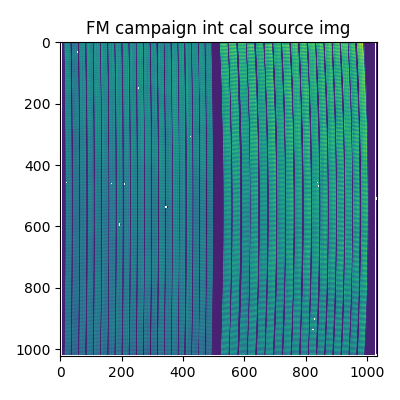

<IPython.core.display.Javascript object>


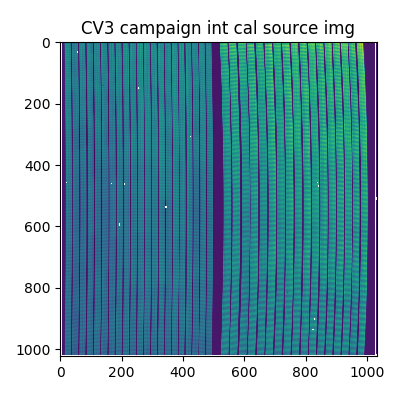

<IPython.core.display.Javascript object>


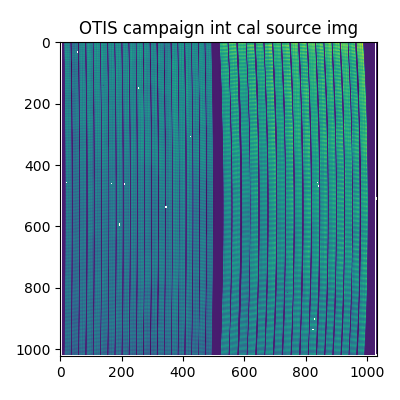

<IPython.core.display.Javascript object>


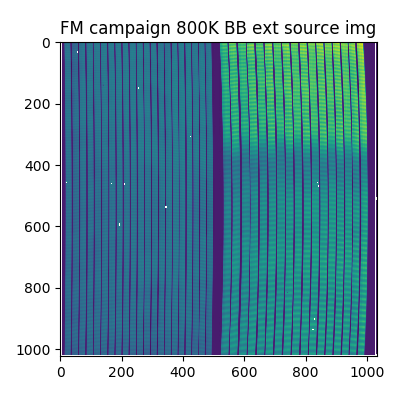

In [6]:
# make plots
plt.close('all')
plt.figure(figsize=(4,4))
plt.imshow(fm_intcalsource_sciimg)
plt.title('FM campaign int cal source img')
plt.tight_layout()

plt.figure(figsize=(4,4))
plt.imshow(cv3_intcalsource_sciimg)
plt.title('CV3 campaign int cal source img')
plt.tight_layout()

plt.figure(figsize=(4,4))
plt.imshow(otis_intcalsource_sciimg)
plt.title('OTIS campaign int cal source img')
plt.tight_layout()

plt.figure(figsize=(4,4))
plt.imshow(fm_extsource_sciimg)
plt.title('FM campaign 800K BB ext source img')
plt.tight_layout()

<IPython.core.display.Javascript object>


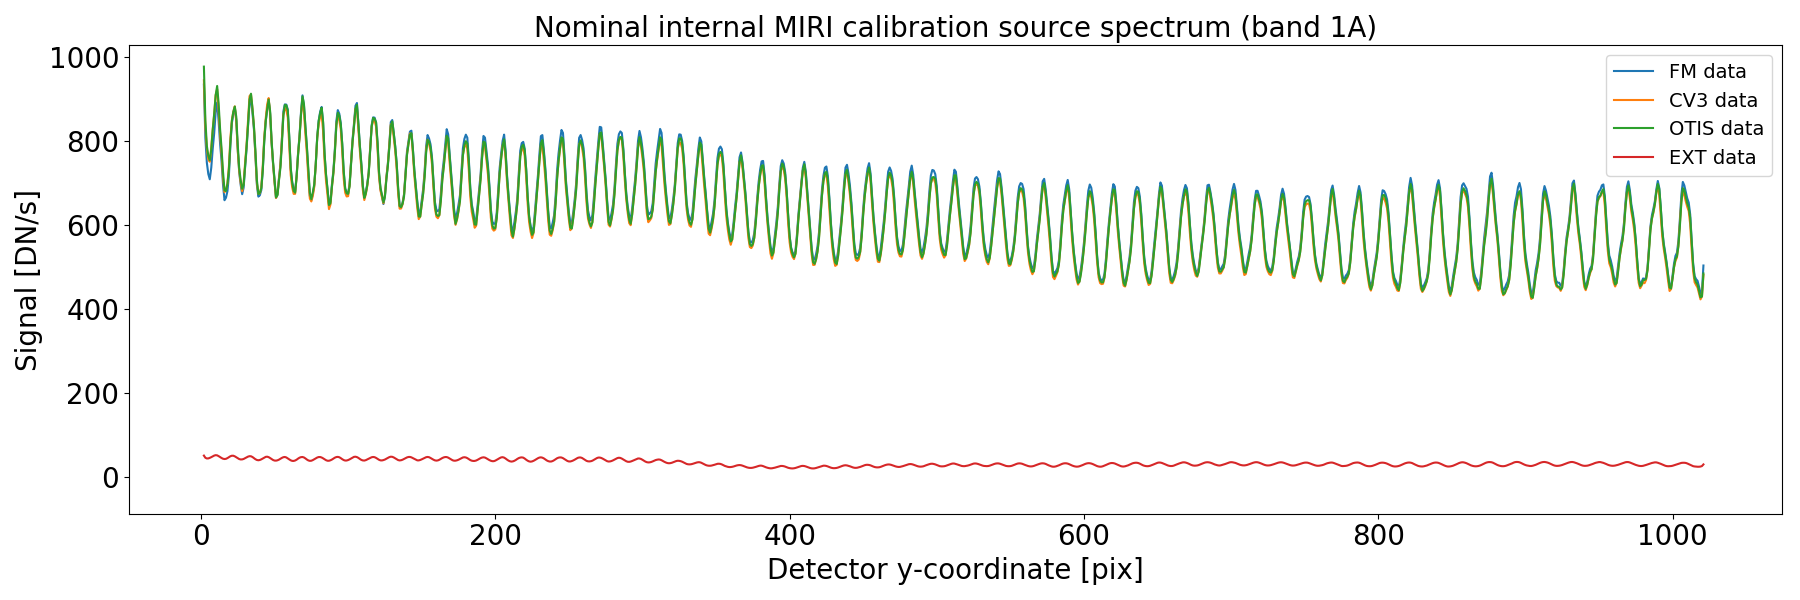

In [6]:
plt.figure(figsize=frame)
plt.plot(fm_intcalsource_sciimg[:,col],label='FM data')
plt.plot(cv3_intcalsource_sciimg[:,col],label='CV3 data')
plt.plot(otis_intcalsource_sciimg[:,col],label='OTIS data')
plt.plot(fm_extsource_sciimg[:,col],label='EXT data')
plt.xlabel('Detector y-coordinate [pix]',fontsize=20)
plt.ylabel('Signal [DN/s]',fontsize=20)
plt.title('Nominal internal MIRI calibration source spectrum (band 1A)',fontsize=20)
plt.legend(loc='upper right',fontsize=14)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()

<IPython.core.display.Javascript object>


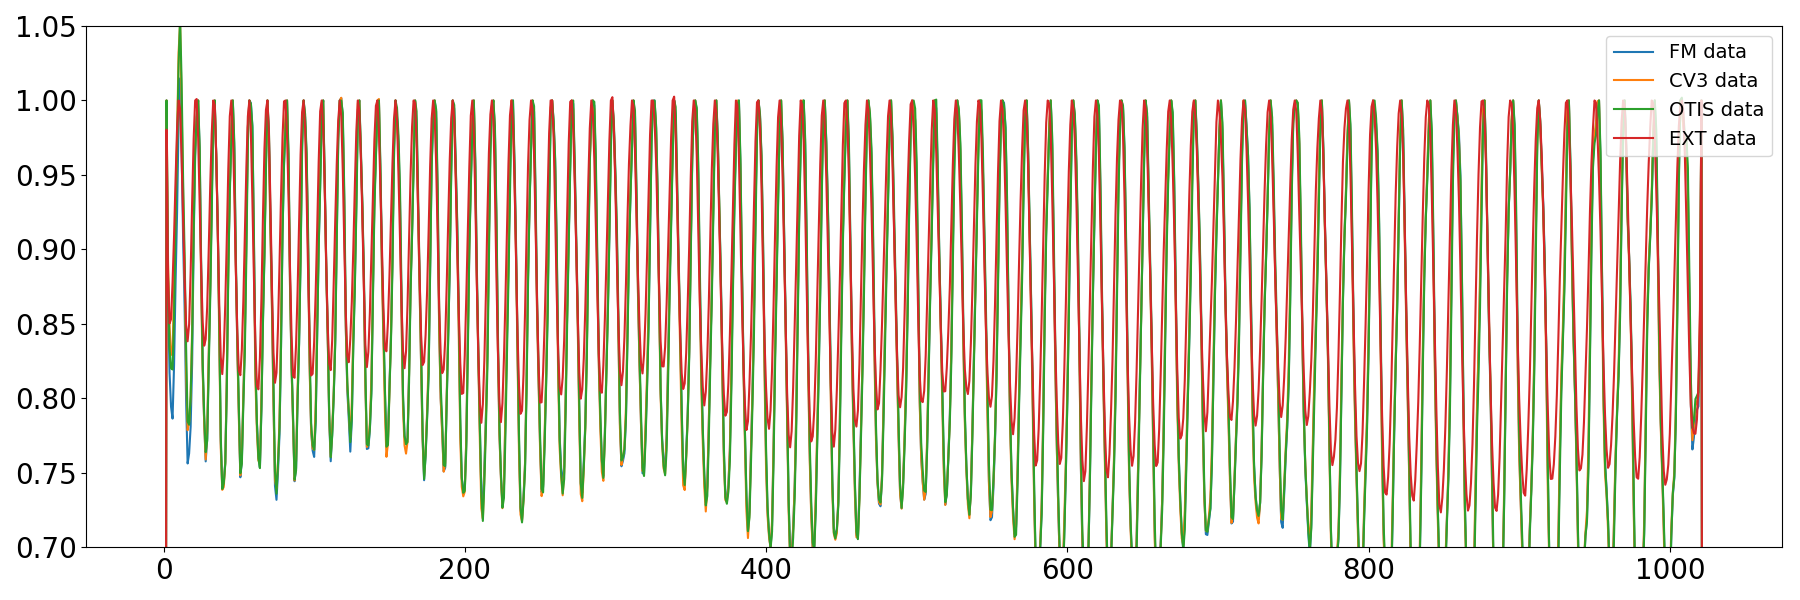

In [7]:
plt.close('all')
# plt.figure(figsize=frame)
# plt.plot(fm_data_noNaN,label='FM data')
# plt.plot(fm_peaks,fm_data_noNaN[fm_peaks],'ro')
# plt.plot(fm_data_profile,'r')
# plt.legend(loc='upper right',fontsize=14)
# plt.tick_params(axis='both',labelsize=20)
# plt.tight_layout()

# plt.figure(figsize=frame)
# plt.plot(cv3_data_noNaN,label='CV3 data')
# plt.plot(cv3_peaks,cv3_data_noNaN[cv3_peaks],'ro')
# plt.plot(cv3_data_profile,'r')
# plt.legend(loc='upper right',fontsize=14)
# plt.tick_params(axis='both',labelsize=20)
# plt.tight_layout()

# plt.figure(figsize=frame)
# plt.plot(otis_data_noNaN,label='OTIS data')
# plt.plot(otis_peaks,otis_data_noNaN[otis_peaks],'ro')
# plt.plot(otis_data_profile,'r')
# plt.legend(loc='upper right',fontsize=14)
# plt.tick_params(axis='both',labelsize=20)
# plt.tight_layout()

# plt.figure(figsize=frame)
# plt.plot(ext_data_noNaN,label='EXT data')
# plt.plot(ext_peaks,ext_data_noNaN[ext_peaks],'ro')
# plt.plot(ext_data_profile,'r')
# plt.legend(loc='upper right',fontsize=14)
# plt.tick_params(axis='both',labelsize=20)
# plt.tight_layout()

plt.figure(figsize=frame)
plt.plot(fm_data_noNaN/fm_data_profile,label='FM data')
plt.plot(cv3_data_noNaN/cv3_data_profile,label='CV3 data')
plt.plot(otis_data_noNaN/otis_data_profile,label='OTIS data')
plt.plot(ext_data_noNaN/ext_data_profile,label='EXT data')
plt.ylim(0.7,1.05)
plt.legend(loc='upper right',fontsize=14)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()

# Internal Calibration Source - empirical fringe fitting

In [9]:
band = '2A'

#> detector dimensions in pixels
det_dims = (1024,1032)
# compute coordinate maps for spectral band
d2cMaps = d2cMapping(band,cdpDir)
# extract single maps
sliceMap  = d2cMaps['sliceMap']
alphaMap  = d2cMaps['alphaMap']
betaMap   = d2cMaps['betaMap']
lambdaMap = d2cMaps['lambdaMap']
wvnrMap   = 1./(lambdaMap/10000.)
nslices   = maux.MRS_nslices[band[0]]
bzero     = d2cMaps['bzero']
bdel      = d2cMaps['bdel']
mrs_fwhm  = maux.MRS_FWHM[band[0]]

bandlims = [lambdaMap[np.nonzero(lambdaMap)].min(),lambdaMap[np.nonzero(lambdaMap)].max()]
fov_lims = [alphaMap[np.nonzero(lambdaMap)].min(),alphaMap[np.nonzero(lambdaMap)].max()]
unique_betas = np.sort(np.unique(betaMap[(sliceMap>100*int(band[0])) & (sliceMap<100*(int(band[0])+1))]))

<IPython.core.display.Javascript object>


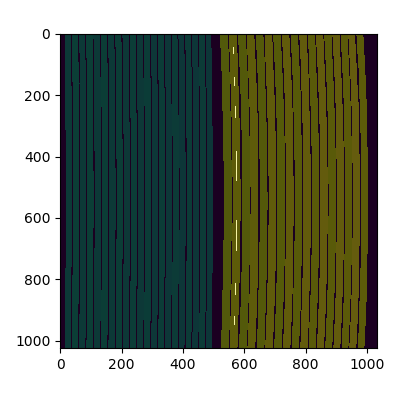

In [37]:
islice = 10

img0,img = np.full(det_dims,0.),np.full(det_dims,0.)
sel = (sliceMap == 100*int(band[0])+islice)
img0[sel] = sliceMap[sel]
img[sel] = alphaMap[sel]
ypos = np.arange(det_dims[0])
xpos = np.zeros(len(ypos))

alpha_position = 0.
for i in ypos:
    if band[0] in ['1','3']:
        xpos[i] = np.argmin(img[i,:])+funcs.find_nearest(img[i,:][(img0[i,:]!=0)],alpha_position)
    elif band[0] in ['2','4']:
        xpos[i] = np.argmax(img[i,:])+funcs.find_nearest(img[i,:][(img0[i,:]!=0)],alpha_position)
xpos = xpos.astype(int)

# plot trace
valid_img = np.zeros(det_dims)
valid_img[ypos,xpos] = 1.
plt.figure(figsize=(4,4))
plt.imshow(valid_img,cmap='gray')
plt.imshow(sliceMap,alpha=0.4)
plt.tight_layout()

Min_dist between subsequent peaks: 10 elements (pixels)
Case 3


<IPython.core.display.Javascript object>


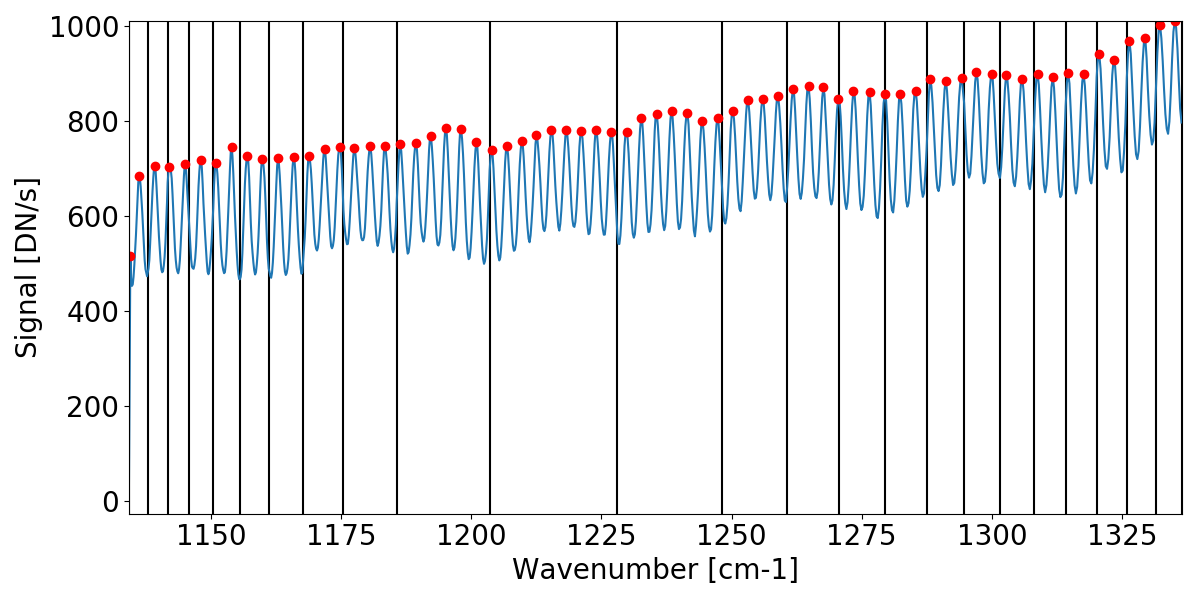

<IPython.core.display.Javascript object>


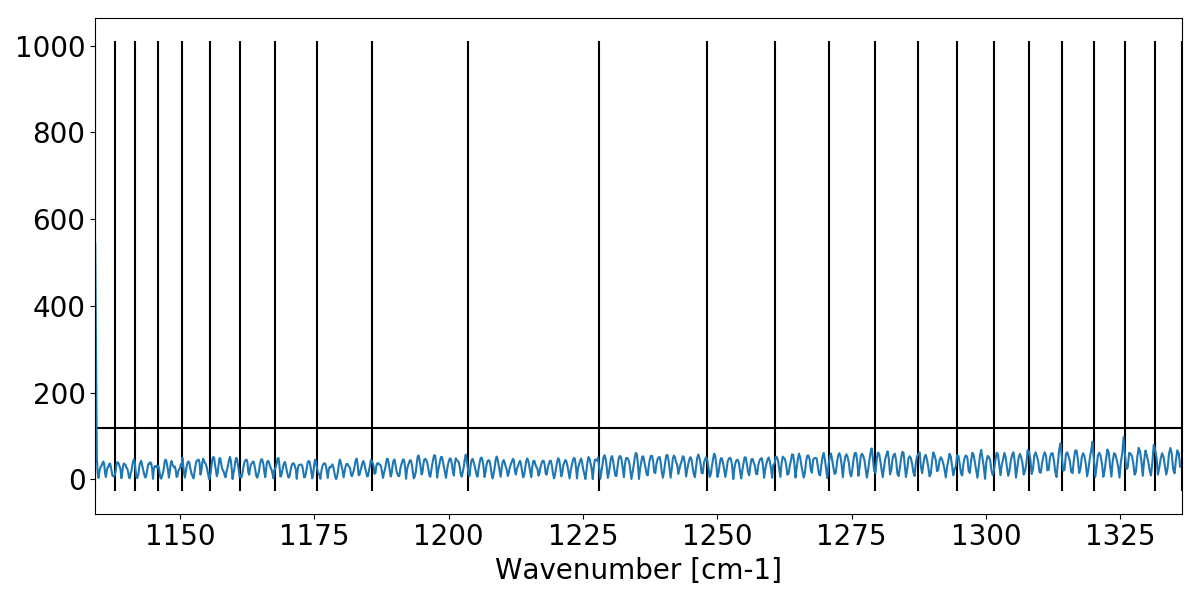

<IPython.core.display.Javascript object>


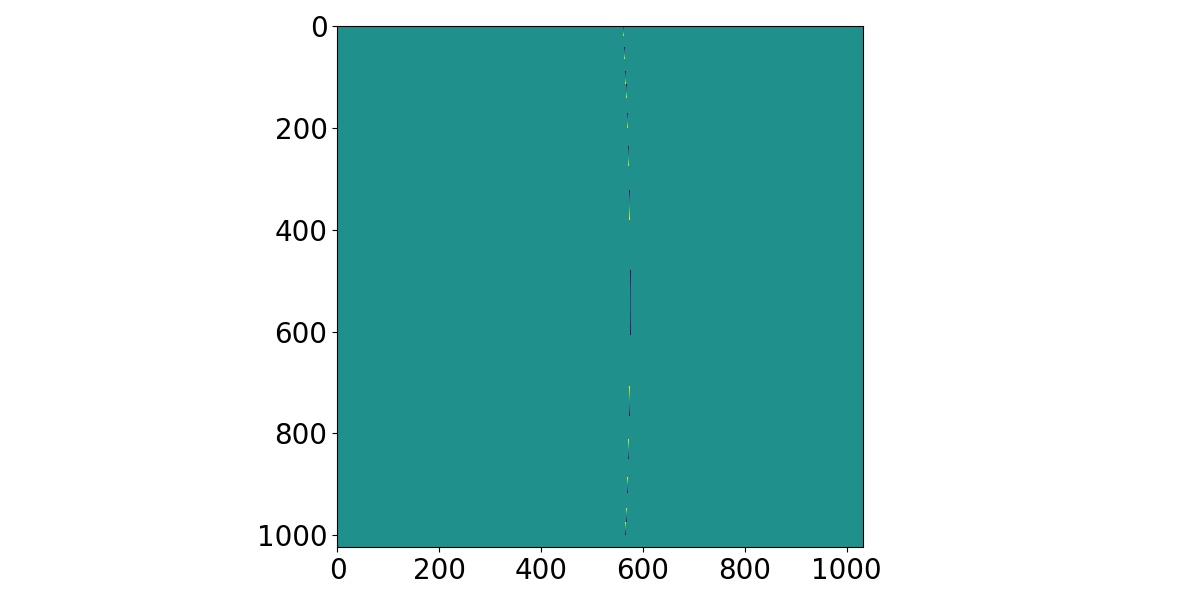

In [38]:
# extract spectrum
wvnr = np.flipud(wvnrMap[ypos,xpos])
extracted_spectrum = np.flipud(fm_intcalsource_sciimg[ypos,xpos])

# fringe peaks are found according to two parameters
# 1) threshold
thres = 0
# 2) minimum distance between subsequent peaks
detsubstrfringe_wvnr_spacing = (1/0.17)/2. # assuming the detector substrate is always the dominant source of fringing
min_dist = 0
while wvnrMap[512-min_dist,xpos[512-min_dist]]-wvnrMap[512,xpos[512]]<detsubstrfringe_wvnr_spacing :
    min_dist+=1
min_dist = int(round(min_dist/1.6))
print 'Min_dist between subsequent peaks: {} elements (pixels)'.format(min_dist)

# jumps/drops in signal due to displacement in pixel column
discont_idxs = np.unique(np.sort(len(extracted_spectrum)-1-1-np.where((np.abs(np.diff(xpos))>=1))[0]))+1
discont_idxs = np.concatenate([discont_idxs,np.array([len(extracted_spectrum)-1])])

# omit sections with too few elements
bad_sections = []
for i in range(len(discont_idxs)-1):
    if discont_idxs[i+1]-discont_idxs[i] <= min_dist:
        if discont_idxs[i+1] == -1:
            extracted_spectrum[discont_idxs[i]:] = np.nan
            bad_sections.extend([i,i+1])
        elif discont_idxs[i] == 0:
            extracted_spectrum[:discont_idxs[i+1]] = np.nan
            bad_sections.extend([i,i+1])
        else:
            extracted_spectrum[discont_idxs[i]-1:discont_idxs[i+1]+1] = np.nan
            bad_sections.extend([i,i+1])
discont_idxs = np.delete(discont_idxs,bad_sections)

omit_nan = ~np.isnan(extracted_spectrum).copy()
wvnr_noNaN = wvnr[omit_nan]
extracted_spectrum_noNaN = extracted_spectrum[omit_nan]

# second iteration
discont_idxs = np.unique(np.sort(len(extracted_spectrum_noNaN)-1-1-np.where((np.abs(np.diff(xpos[np.flipud(omit_nan)]))>=1))[0]))+1
if discont_idxs[0] != 0:
    discont_idxs = np.concatenate((np.array([0]),discont_idxs))
if discont_idxs[-1] != len(extracted_spectrum_noNaN)-1:
    discont_idxs = np.concatenate((discont_idxs,np.array([len(extracted_spectrum_noNaN)-1])))

outlier_condition = 5*np.std(np.abs(np.diff(extracted_spectrum_noNaN))) # five sigma
outliers = np.where(np.abs(np.diff(extracted_spectrum_noNaN)) > outlier_condition)[0]
invalid_outlier_idxs = [i for i in range(len(outliers)) if outliers[i] in discont_idxs-1]
outliers = np.delete(outliers,invalid_outlier_idxs)

test_case = funcs.find_peaks(np.abs(np.diff(extracted_spectrum_noNaN)),thres=outlier_condition/np.max(np.abs(np.diff(extracted_spectrum_noNaN))),min_dist=min_dist)
invalid_testcase_idxs = [i for i in range(len(test_case)) if test_case[i] in outliers]
test_case = np.delete(test_case,invalid_testcase_idxs)
# alpha_position = np.mean(alpha_centers[~np.isnan(alpha_centers)])
if (len(test_case) != 0) & (set(test_case).issubset(discont_idxs[(discont_idxs!=0)]-1)) & (alpha_position < 0):
    case = '1'
elif (len(test_case) != 0) & (set(test_case).issubset(discont_idxs[(discont_idxs!=0)]-1)) & (alpha_position > 0):
    case = '2'
else:
    case = '3'
print 'Case {}'.format(case)

if case in ['1','2']:
    peaks_idxs = []
    pseudo_wvnr = []
    pseudo_contin = []
    for i in range(len(discont_idxs)-1):
        idx1,idx2 = discont_idxs[i],discont_idxs[i+1]
        pseudo_continuum = ((extracted_spectrum_noNaN[idx2-1]-extracted_spectrum_noNaN[idx1])/(wvnr_noNaN[idx2-1]-wvnr_noNaN[idx1]))*(np.linspace(wvnr_noNaN[idx1],wvnr_noNaN[idx2],idx2-idx1)-wvnr_noNaN[idx1])+extracted_spectrum_noNaN[idx1]
        # could try a 4th order polynomial for the pseudo_continuum, but too time consuming?..
        peak_idxs = idx1+funcs.find_peaks(extracted_spectrum_noNaN[idx1:idx2]-pseudo_continuum,thres=thres,min_dist=min_dist)
        invalid_peaks = [j for j in range(len(peak_idxs)) if peak_idxs[j] in outliers+1]
        peak_idxs = np.delete(peak_idxs,invalid_peaks)
        peaks_idxs.extend(peak_idxs)
        pseudo_wvnr.extend(wvnr_noNaN[idx1:idx2])
        pseudo_contin.extend(pseudo_continuum)
elif case == '3':
    peaks_idxs = funcs.find_peaks(extracted_spectrum_noNaN,thres=thres,min_dist=min_dist)

plt.close('all')
plt.figure(figsize=(12,6))
plt.plot(wvnr_noNaN,extracted_spectrum_noNaN)
if case in ['1','2']:
    plt.plot(pseudo_wvnr,pseudo_contin)
plt.plot(wvnr_noNaN[peaks_idxs],extracted_spectrum_noNaN[peaks_idxs],'ro')
plt.vlines(wvnr_noNaN[discont_idxs],extracted_spectrum_noNaN.min(),extracted_spectrum_noNaN.max())
plt.xlim(wvnr_noNaN.min(),wvnr_noNaN.max())
plt.ylim(extracted_spectrum_noNaN.min(),extracted_spectrum_noNaN.max())
plt.xlabel('Wavenumber [cm-1]',fontsize=20)
plt.ylabel('Signal [DN/s]',fontsize=20)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()

plt.figure(figsize=(12,6))
plt.plot(wvnr_noNaN[:-1],np.abs(np.diff(extracted_spectrum_noNaN)) )
plt.plot(wvnr_noNaN[:-1][test_case],np.abs(np.diff(extracted_spectrum_noNaN))[test_case],'ro' )
plt.hlines(outlier_condition,wvnr_noNaN.min(),wvnr_noNaN.max())
plt.vlines(wvnr_noNaN[discont_idxs],extracted_spectrum_noNaN.min(),extracted_spectrum_noNaN.max())
plt.xlim(wvnr_noNaN.min(),wvnr_noNaN.max())
plt.xlabel('Wavenumber [cm-1]',fontsize=20)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()

# Spectrum origination on detector
img2 = np.full(det_dims,0.)
img2[ypos,xpos] = alphaMap[ypos,xpos]

plt.figure(figsize=(12,6))
plt.imshow(img2,zorder=0)
# plt.imshow(sliceMap,alpha=0.4,zorder=1)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()



<IPython.core.display.Javascript object>


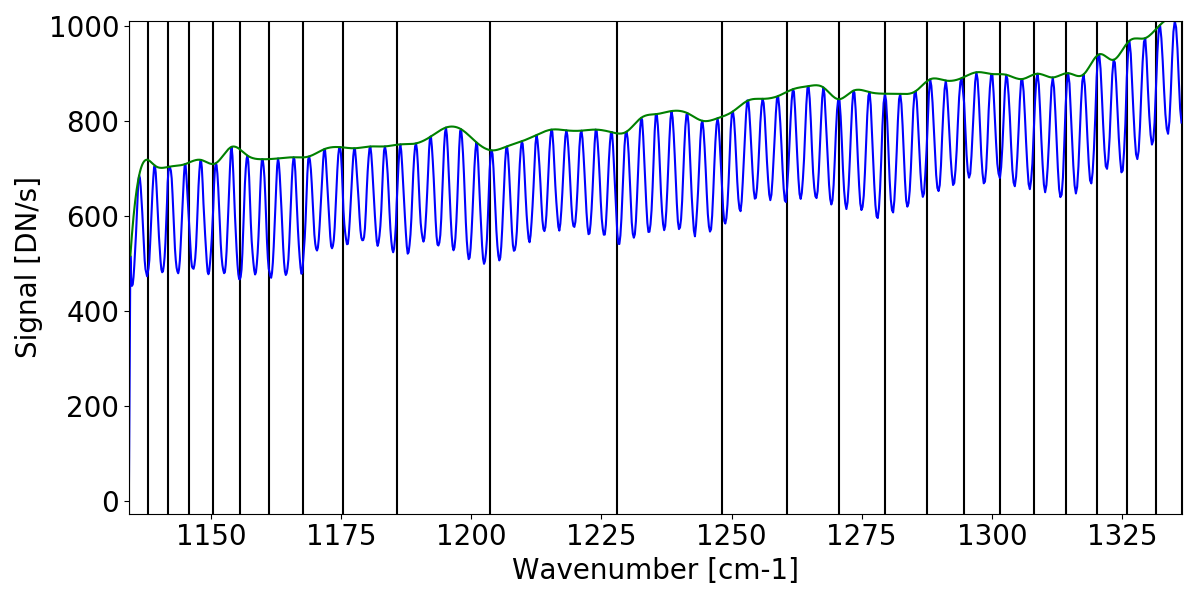

<IPython.core.display.Javascript object>


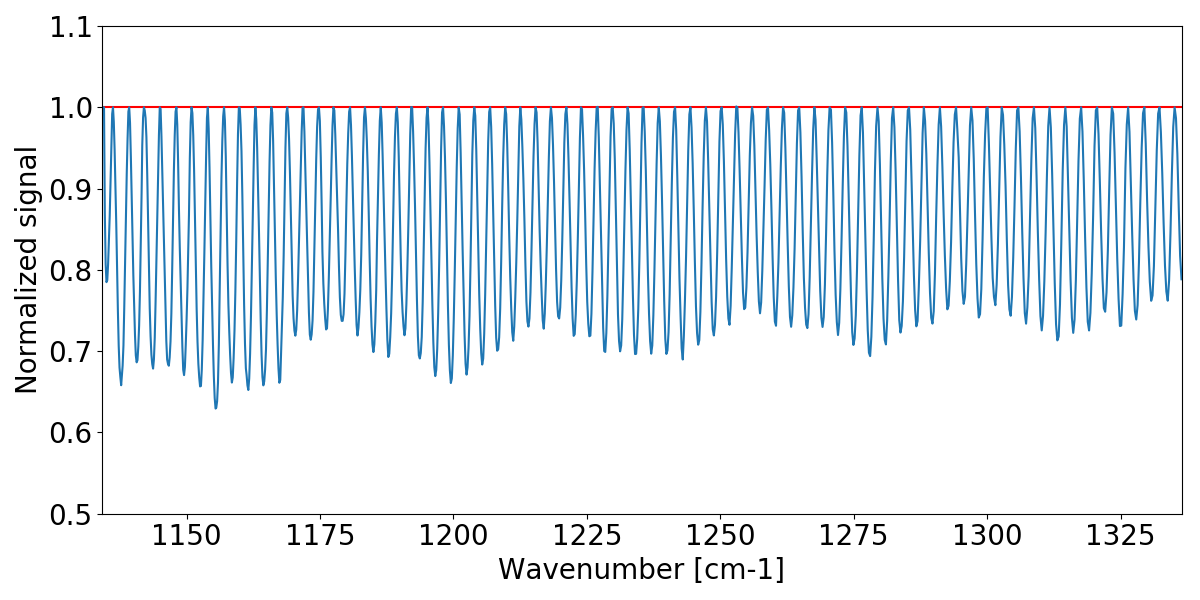

In [39]:
# Scale to 1d spectrum continuum level (defined by fringe peaks)
#-- construct continuum level
if case in ['1','2']:
    arr_profile = []
    for i in range(len(discont_idxs)-1):
        idx1,idx2 = discont_idxs[i],discont_idxs[i+1]
        if idx2 == len(extracted_spectrum_noNaN)-1:
            pseudo_continuum = ((extracted_spectrum_noNaN[len(extracted_spectrum_noNaN)-1]-extracted_spectrum_noNaN[idx1])/(wvnr_noNaN[len(extracted_spectrum_noNaN)-1]-wvnr_noNaN[idx1]))*(np.linspace(wvnr_noNaN[idx1],wvnr_noNaN[len(extracted_spectrum_noNaN)-1],len(extracted_spectrum_noNaN)-idx1)-wvnr_noNaN[idx1])+extracted_spectrum_noNaN[idx1]
            peak_idxs = funcs.find_peaks(extracted_spectrum_noNaN[idx1:]-pseudo_continuum,thres=thres,min_dist=min_dist)
            invalid_peaks = [j for j in range(len(peak_idxs)) if idx1+peak_idxs[j] in outliers+1]
            peaks_idxs = np.delete(peak_idxs,invalid_peaks)
            if len(peaks_idxs) == 2:
                arr_interpolator = scp_interpolate.InterpolatedUnivariateSpline(peaks_idxs,extracted_spectrum_noNaN[idx1:][peaks_idxs],k=1,ext=0)
                arr_profile.extend(arr_interpolator(range(len(extracted_spectrum_noNaN[idx1:]))) )
            elif len(peaks_idxs) == 3:
                arr_interpolator = scp_interpolate.InterpolatedUnivariateSpline(peaks_idxs,extracted_spectrum_noNaN[idx1:][peaks_idxs],k=2,ext=0)
                arr_profile.extend(arr_interpolator(range(len(extracted_spectrum_noNaN[idx1:]))) )
            elif len(peaks_idxs) > 3:
                arr_interpolator = scp_interpolate.InterpolatedUnivariateSpline(peaks_idxs,extracted_spectrum_noNaN[idx1:][peaks_idxs],k=3,ext=0)
                arr_profile.extend(arr_interpolator(range(len(extracted_spectrum_noNaN[idx1:]))) )
            else:
                arr_profile.extend(extracted_spectrum_noNaN[idx1:])
        else:
            pseudo_continuum = ((extracted_spectrum_noNaN[idx2-1]-extracted_spectrum_noNaN[idx1])/(wvnr_noNaN[idx2-1]-wvnr_noNaN[idx1]))*(np.linspace(wvnr_noNaN[idx1],wvnr_noNaN[idx2],idx2-idx1)-wvnr_noNaN[idx1])+extracted_spectrum_noNaN[idx1]
            peak_idxs = funcs.find_peaks(extracted_spectrum_noNaN[idx1:idx2]-pseudo_continuum,thres=thres,min_dist=min_dist)
            invalid_peaks = [j for j in range(len(peak_idxs)) if idx1+peak_idxs[j] in outliers+1]
            peaks_idxs = np.delete(peak_idxs,invalid_peaks)
            if len(peaks_idxs) == 2:
                arr_interpolator = scp_interpolate.InterpolatedUnivariateSpline(peaks_idxs,extracted_spectrum_noNaN[idx1:idx2][peaks_idxs],k=1,ext=0)
                arr_profile.extend(arr_interpolator(range(len(extracted_spectrum_noNaN[idx1:idx2]))) )
            elif len(peaks_idxs) == 3:
                arr_interpolator = scp_interpolate.InterpolatedUnivariateSpline(peaks_idxs,extracted_spectrum_noNaN[idx1:idx2][peaks_idxs],k=2,ext=0)
                arr_profile.extend(arr_interpolator(range(len(extracted_spectrum_noNaN[idx1:idx2]))) )
            elif len(peaks_idxs) > 3:
                arr_interpolator = scp_interpolate.InterpolatedUnivariateSpline(peaks_idxs,extracted_spectrum_noNaN[idx1:idx2][peaks_idxs],k=3,ext=0)
                arr_profile.extend(arr_interpolator(range(len(extracted_spectrum_noNaN[idx1:idx2]))) )
            else:
                arr_profile.extend(extracted_spectrum_noNaN[idx1:idx2])
    arr_profile = np.array(arr_profile)
elif case == '3':
    peaks_idxs = funcs.find_peaks(extracted_spectrum_noNaN,thres=thres,min_dist=min_dist)
    arr_interpolator = scp_interpolate.InterpolatedUnivariateSpline(peaks_idxs,extracted_spectrum_noNaN[peaks_idxs],k=3,ext=3)
    arr_profile = arr_interpolator(range(len(extracted_spectrum_noNaN)))

plt.close('all')
plt.figure(figsize=(12,6))
plt.plot(wvnr_noNaN,extracted_spectrum_noNaN,'b')
plt.plot(wvnr_noNaN,arr_profile,'g')
# black lines indicate transition in pixel column (equivalent to visible jump/drop in signal)
plt.vlines(wvnr_noNaN[discont_idxs],extracted_spectrum_noNaN.min(),extracted_spectrum_noNaN.max())
plt.xlim(wvnr_noNaN.min(),wvnr_noNaN.max())
plt.ylim(extracted_spectrum_noNaN.min(),extracted_spectrum_noNaN.max())
plt.xlabel('Wavenumber [cm-1]',fontsize=20)
plt.ylabel('Signal [DN/s]',fontsize=20)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()

norm_profile = extracted_spectrum_noNaN/arr_profile
norm_profile[(norm_profile <= 0.6)] = 1 # fringe amplitude cannot be more that 40% of signal
norm_profile[(norm_profile >= 1.4)] = 1
    
plt.figure(figsize=(12,6))
plt.plot(wvnr_noNaN,norm_profile)
plt.hlines(1,wvnr_noNaN.min(),wvnr_noNaN.max(),'r')
plt.xlim(wvnr_noNaN.min(),wvnr_noNaN.max())
plt.ylim(0.5,1.1)
plt.xlabel('Wavenumber [cm-1]',fontsize=20)
plt.ylabel('Normalized signal',fontsize=20)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()


<IPython.core.display.Javascript object>


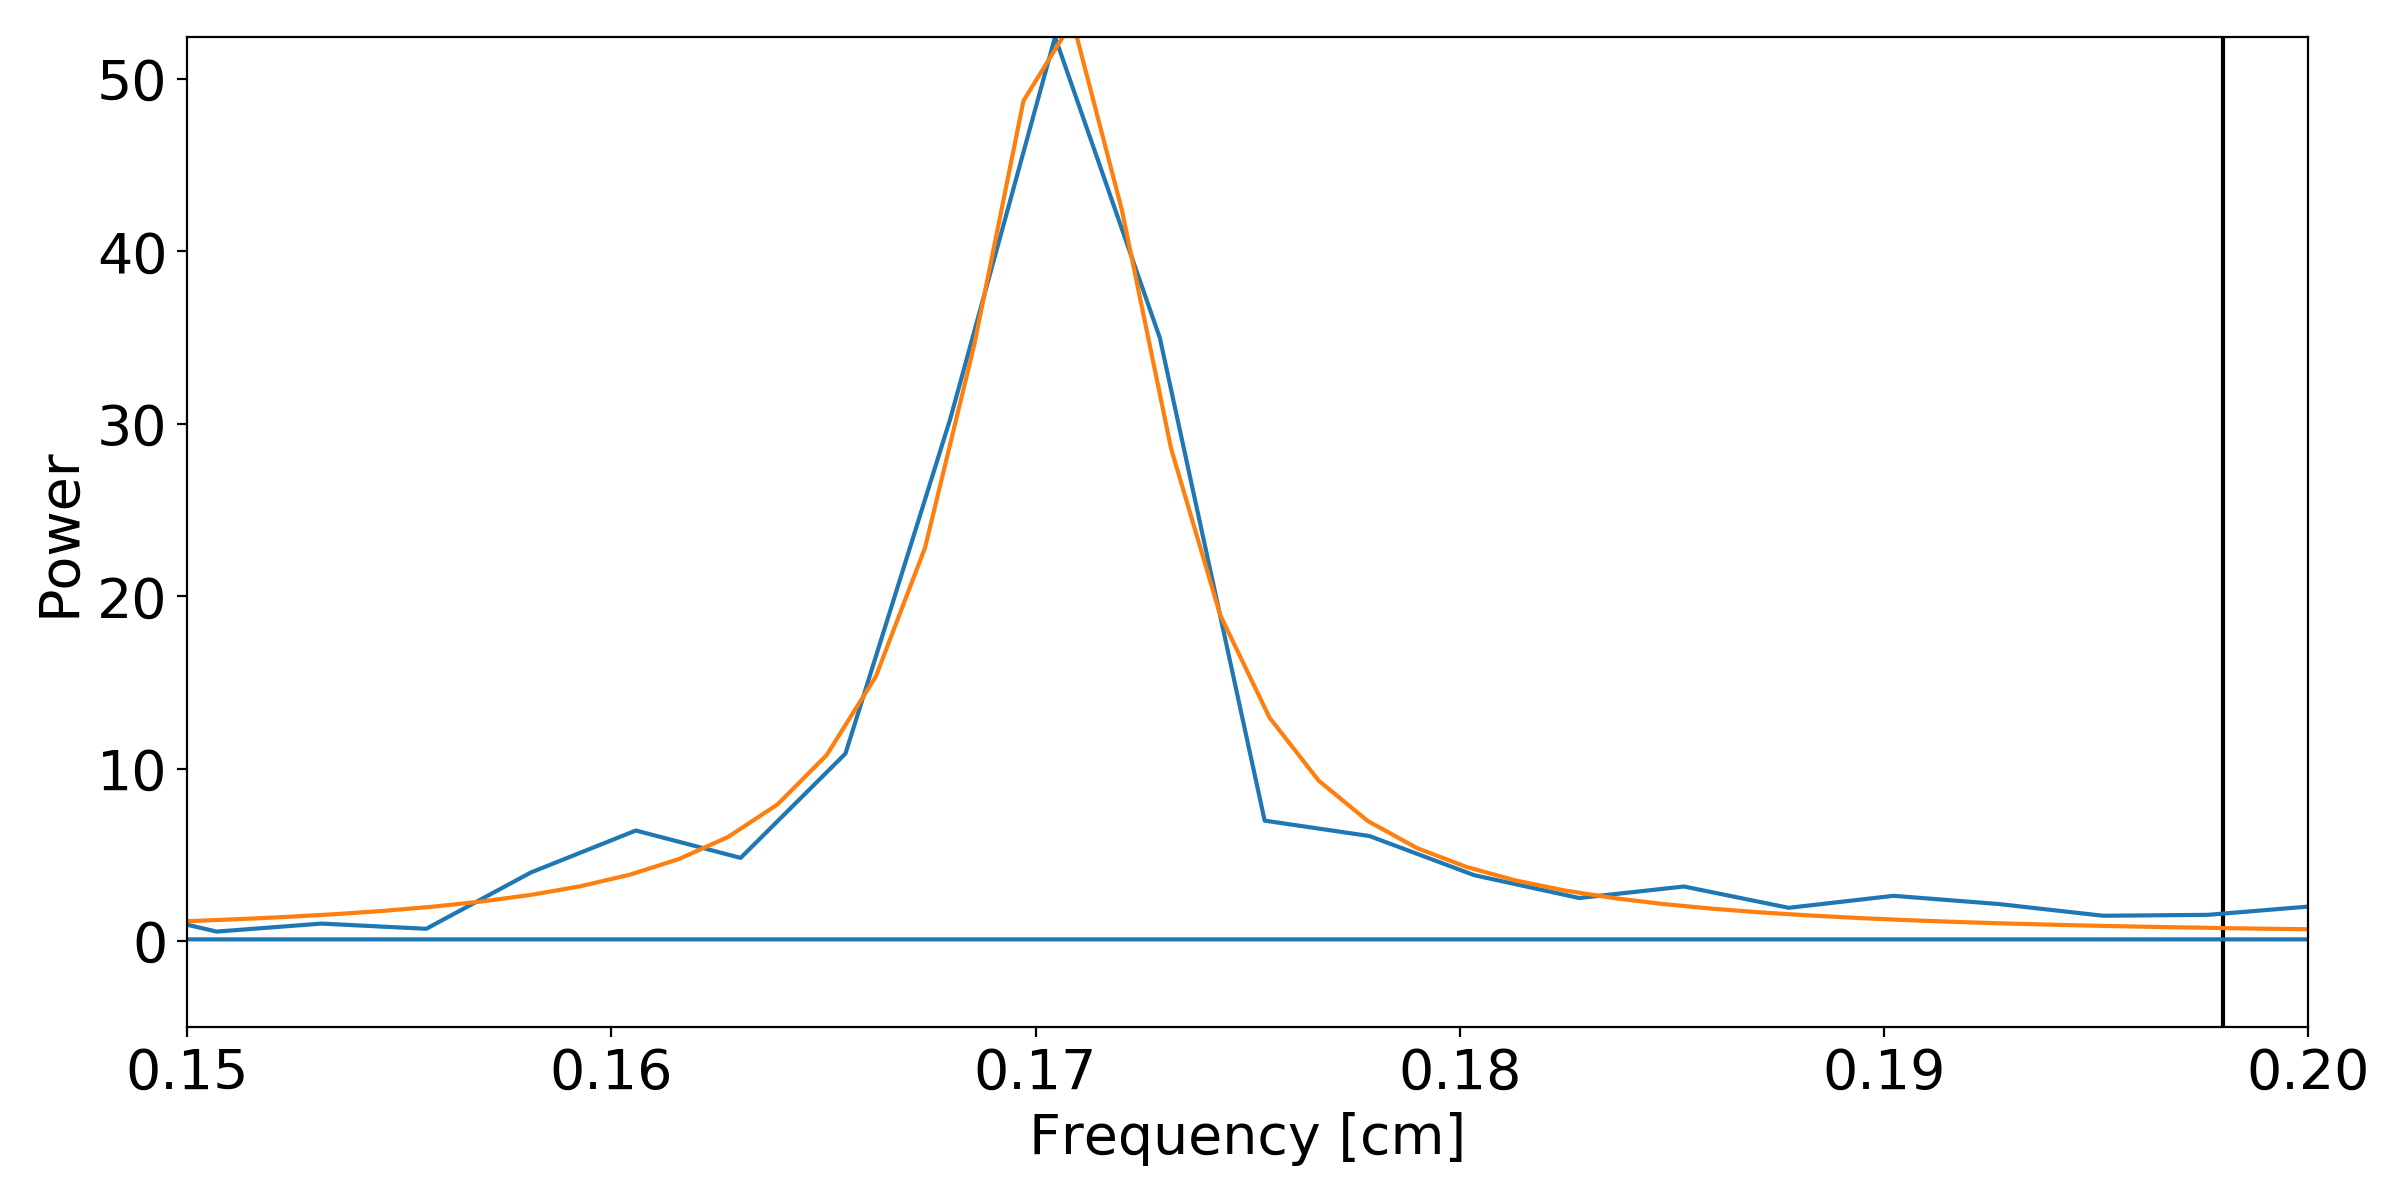

<IPython.core.display.Javascript object>


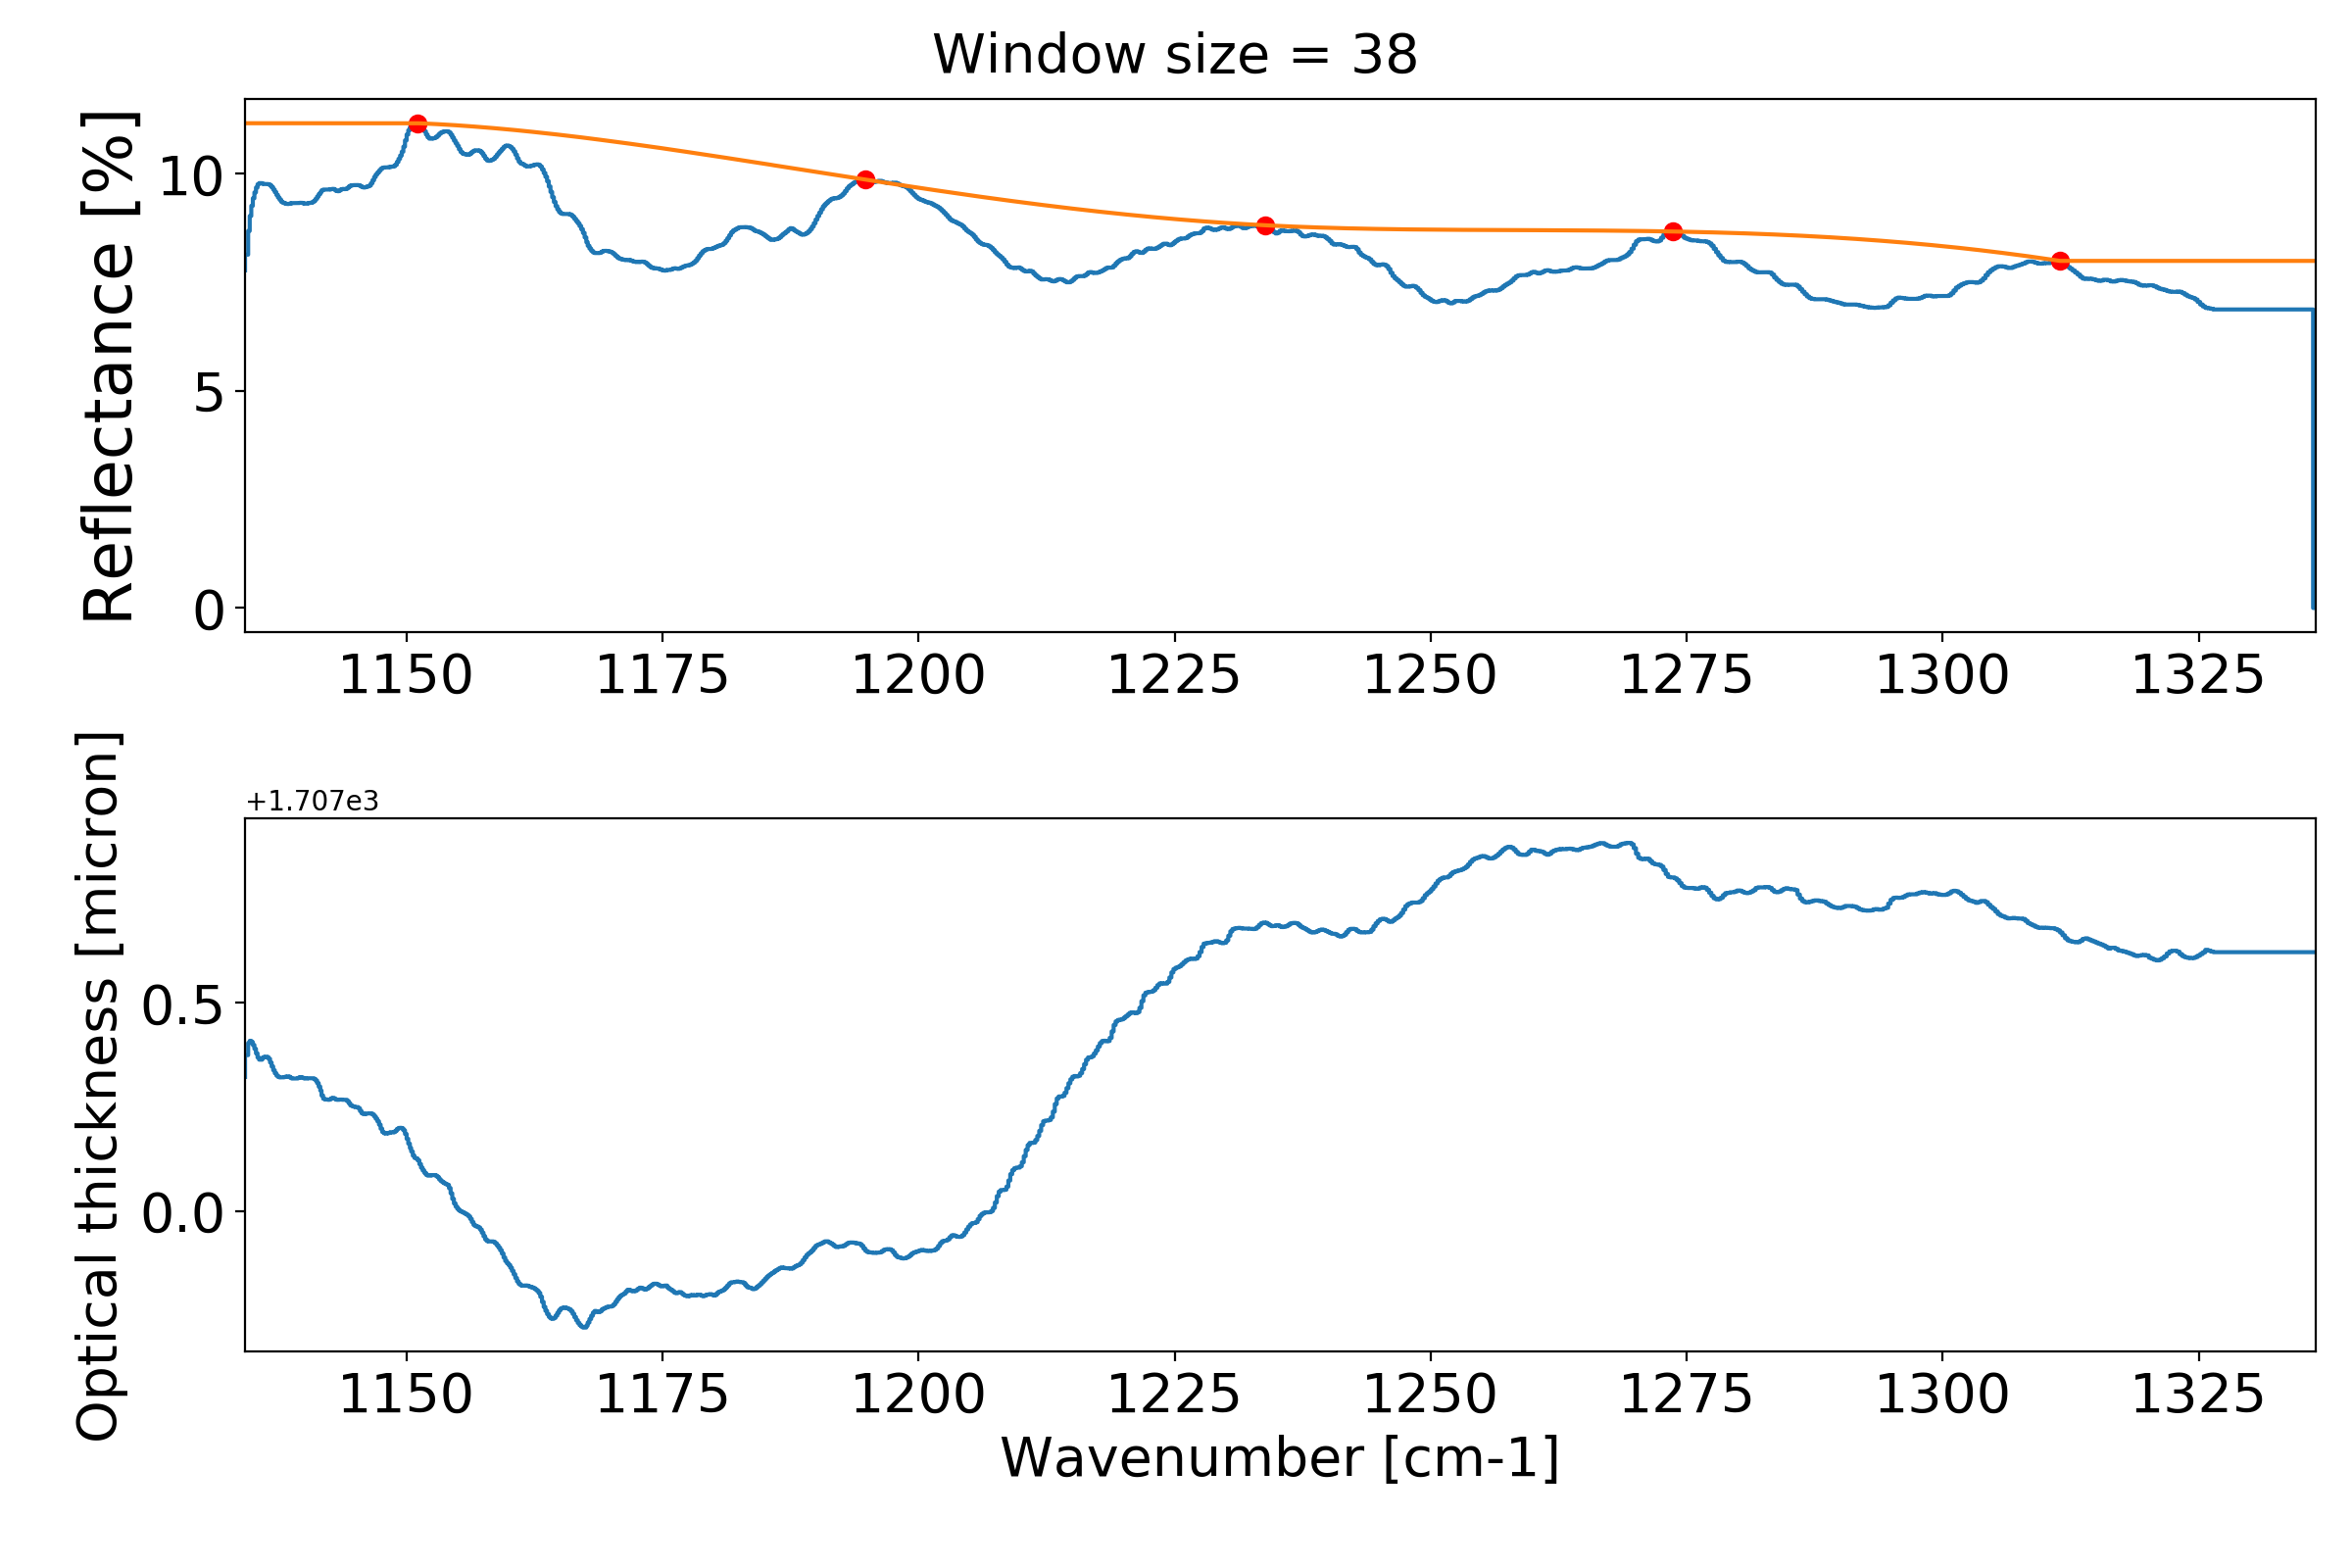

<IPython.core.display.Javascript object>


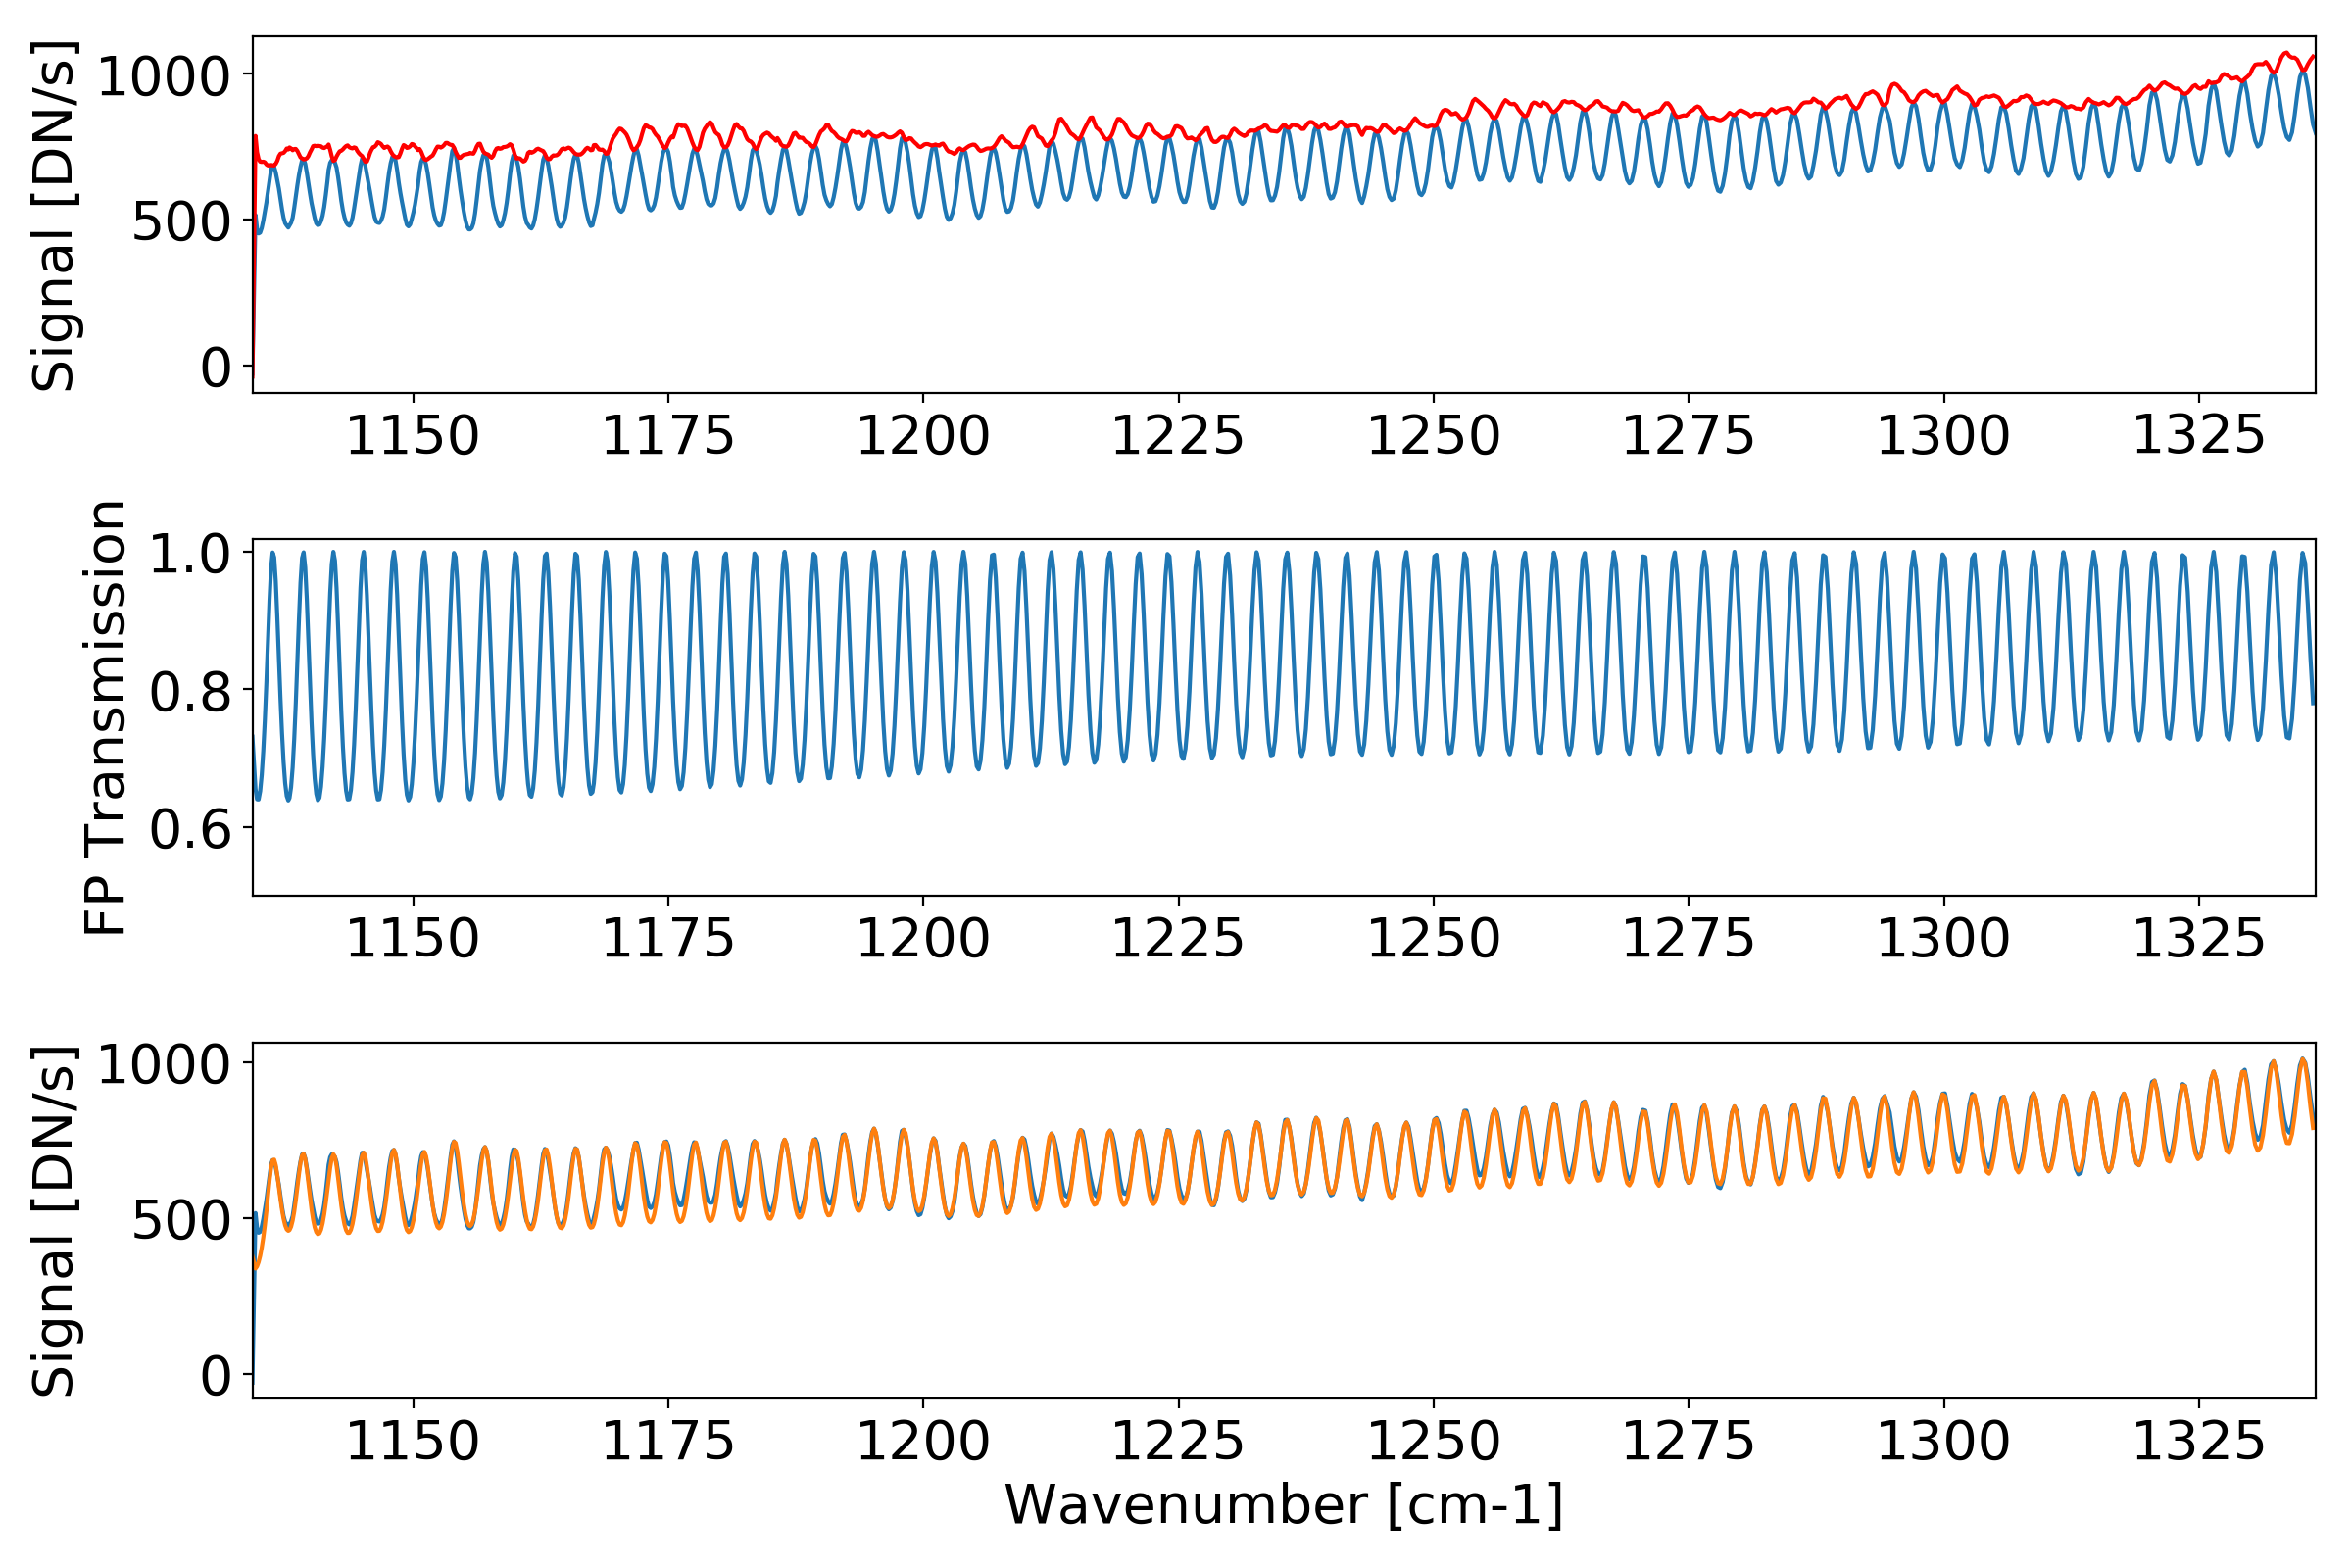

In [50]:
# perform above generic analysis, in shorter wavenumber segments
wvnr = wvnr_noNaN.copy()
arr  = norm_profile.copy()

wvnr_equi = np.linspace(wvnr[0],wvnr[-1],len(wvnr))
arr_equi  = scp_interpolate.interp1d(wvnr,arr)(wvnr_equi)

freq = np.fft.fftfreq(wvnr_equi.shape[-1],d=np.diff(wvnr_equi)[0])/2. # nyquist frequency
sp = np.fft.fft(arr_equi)
power = np.sqrt(sp.real**2 + sp.imag**2)

if case == '1':
    try:
        flag = 0
        continuum = signal.medfilt(power[~np.isnan(power)],kernel_size=21)
        popt0,pcov0 = curve_fit(funcs.lorentzian_profile,freq[freq>=0.1],(power-continuum)[freq>=0.1],p0=[np.max((power-continuum)[freq>=0.1]),freq[freq>=0.1][np.argmax((power-continuum)[freq>=0.1])],0.005])
    except RuntimeError:
        flag = 1
        popt0,pcov0 = curve_fit(funcs.lorentzian_profile,freq[freq>=0.1],power[freq>=0.1]-np.mean(power[(freq>=0.3)]),p0=[np.max(power[freq>=0.1]),freq[freq>=0.1][np.argmax(power[freq>=0.1])],0.005])
elif case in ['2','3']:
    flag = 0
    popt0,pcov0 = curve_fit(funcs.lorentzian_profile,freq[freq>=0.1],power[freq>=0.1]-np.mean(power[(freq>=0.3)]),p0=[np.max(power[freq>=0.1]),freq[freq>=0.1][np.argmax(power[freq>=0.1])],0.005])
# print np.max(power[freq>=0.1]),freq[freq>=0.1][np.argmax(power[freq>=0.1])]
# print popt0

if (case == '1') & (flag == 0):
    plt.figure(figsize=(12,6))
    plt.plot(freq,power)
    plt.plot(freq,continuum)
    plt.ylim(0,20)
    plt.xlabel('Frequency [cm]',fontsize=20)
    plt.ylabel('Power',fontsize=20)
    plt.tick_params(axis='both',labelsize=20)
    plt.tight_layout()

plt.figure(figsize=(12,6))
if (case == '1') & (flag == 0):
    plt.plot(freq,power-continuum)
    testx = np.linspace(freq[freq>=0.1][0],freq[freq>=0.1][-1],1000)
    testy = funcs.lorentzian_profile(testx,*popt0)
    plt.plot(testx,testy)
elif (case == '1') & (flag == 1):
    plt.plot(freq,power)
    testx = np.linspace(freq[freq>=0.1][0],freq[freq>=0.1][-1],1000)
    testy = funcs.lorentzian_profile(testx,*popt0)
    plt.plot(testx,testy+np.mean(power[(freq>=0.3)]))
elif case in ['2','3']:
    plt.plot(freq,power)
    testx = np.linspace(freq[freq>=0.1][0],freq[freq>=0.1][-1],1000)
    testy = funcs.lorentzian_profile(testx,*popt0)
    plt.plot(testx,testy+np.mean(power[(freq>=0.3)]))
plt.vlines([popt0[1]-5*popt0[2],popt0[1]+5*popt0[2]],-10,200)
plt.xlim(freq.min(),freq.max())
plt.xlim(0.15,0.20)
plt.ylim(-5,np.max(power[freq>=0.1]))
plt.xlabel('Frequency [cm]',fontsize=20)
plt.ylabel('Power',fontsize=20)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()


N=1 # number of wavenumber elements
while wvnr[N]-wvnr[0] < 1/popt0[1]:
    N+=1
    
R0,D0 = 0.10,popt0[1]

R,D = [np.full(len(wvnr),np.nan) for j in range(2)]
sigma_R,sigma_D = [np.full(len(wvnr),np.nan) for j in range(2)]
for i in range(len(wvnr)-N):
# for i in [55]:
    wvnr_segment = wvnr[i: N+i].copy()
    arr_segment  = arr[i: N+i].copy()

    # least-squares fitting
    try: 
        popt,pcov = curve_fit(funcs.FPfunc_noPhaseShift,wvnr_segment,arr_segment,p0=(R0,D0),absolute_sigma=True,method='lm')
        TR = funcs.FPfunc_noPhaseShift(wvnr_segment,*popt)

        R[i: N+i] = popt[0]
        D[i: N+i] = popt[1]
        sigma_R[i: N+i] = np.sqrt(np.diag(pcov))[0]
        sigma_D[i: N+i] = np.sqrt(np.diag(pcov))[1]
        
    except RuntimeError: 
        continue

#-- Remove outliers
Rlower = 0.
Dlower,Dupper = 0.14,0.2 # cm, decision based on expected detector thickness (~0.17cm substrate)
R[np.where(R<Rlower)] = np.nan
D[np.where(R<Rlower)] = np.nan
R[np.where(D>Dupper)] = np.nan
R[np.where(D<Dlower)] = np.nan
D[np.where(D>Dupper)] = np.nan
D[np.where(D<Dlower)] = np.nan

# play around with the reflectance values (they should not vary sinusoidally - that's an artifact from the low-frequency fringe)

#> determine local minima/maxima
R[np.isnan(R)] = 0.
R_minima = funcs.find_peaks(R,thres=0,min_dist=150)
arr_interpolator = scp_interpolate.InterpolatedUnivariateSpline(R_minima,R[R_minima],k=3,ext=3)
R_profile = arr_interpolator(range(len(R)))
R[np.isnan(R)] = np.nan


fig,axs = plt.subplots(2,1,figsize=(12,8))
# axs[0].errorbar(wvnr,R*100,yerr=sigma_R*100,fmt='o',label='data')
# axs[0].step(wvnr_intcalsource,R_intcalsource*100,label='data')
axs[0].step(wvnr,R*100,label='data')
axs[0].plot(wvnr[R_minima],R[R_minima]*100,'ro',label='data')
axs[0].plot(wvnr,R_profile*100,label='data')
axs[0].set_xlim(wvnr[0],wvnr[-1])
# axs[0].set_ylim(0)
axs[0].set_ylabel('Reflectance [%]',fontsize=24)
axs[0].tick_params(axis='both',labelsize=20)
# axs[1].errorbar(wvnr,D*10000,yerr=sigma_D*10000,fmt='o',label='data')
# axs[1].step(wvnr_intcalsource,D_intcalsource*10000,label='data')
axs[1].step(wvnr,D*10000,label='data')
axs[1].set_xlim(wvnr[0],wvnr[-1])
axs[1].set_ylabel('Optical thickness [micron]',fontsize=20)
axs[1].tick_params(axis='both',labelsize=20)
axs[1].set_xlabel('Wavenumber [cm-1]',fontsize=20)
plt.suptitle('Window size = {}'.format(N),fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])

# plot result of FP fitting
arr  = extracted_spectrum_noNaN.copy()
reference = arr_profile.copy()

#> manual fitting
TR = (1 + (4*R/(1-R)**2) * np.sin(2*np.pi*D*wvnr*np.cos(0))**2 )**-1
TR = (1 + (4*R_profile/(1-R_profile)**2) * np.sin(2*np.pi*D*wvnr*np.cos(0))**2 )**-1

#> compare with normalized extended source spectrum
ext_data  = fm_extsource_sciimg[ypos,xpos]
ext_data[np.isnan(ext_data)] = -1
ext_peaks = funcs.find_peaks(ext_data,thres=0.,min_dist=min_dist)
ext_data[(ext_data == -1)] = np.nan
ext_data_noNaN = ext_data.copy()
ext_data_noNaN[np.isnan(ext_data)] = 0.
arr_interpolator = scp_interpolate.InterpolatedUnivariateSpline(ext_peaks,ext_data_noNaN[ext_peaks],k=3,ext=3)
ext_data_profile = arr_interpolator(range(len(ext_data_noNaN)))


fig,axs = plt.subplots(3,1,figsize=(12,8))
axs[0].plot(wvnr,arr)
# axs[0].plot(test_wvnr,test_arr)
# axs[0].plot(wvnr,arr_profile)
axs[0].plot(wvnr[~np.isnan(TR)],arr[~np.isnan(TR)]/TR[~np.isnan(TR)],'r')
# axs[0].plot(np.flipud(1/(lambdaMap[ypos,xpos]/10000)),np.flipud(reduced_img[ypos,xpos]/fringe_img[ypos,xpos]),'c')
axs[0].set_xlim(wvnr[0],wvnr[-1])
axs[0].set_ylabel('Signal [DN/s]',fontsize=20)
axs[0].tick_params(axis='both',labelsize=20)
axs[1].plot(wvnr[~np.isnan(TR)],TR[~np.isnan(TR)])
# axs[1].plot(np.flipud(wvnrMap[ypos,xpos])[omit_nan][~np.isnan(TR)],np.flipud((ext_data_noNaN/ext_data_profile))[omit_nan][~np.isnan(TR)])
axs[1].set_xlim(wvnr[0],wvnr[-1])
axs[1].set_ylim(0.5)
axs[1].set_ylabel('FP Transmission',fontsize=20)
axs[1].tick_params(axis='both',labelsize=20)
axs[2].plot(wvnr,arr)
axs[2].plot(wvnr[~np.isnan(TR)],reference[~np.isnan(TR)]*TR[~np.isnan(TR)])
# axs[2].vlines([1915,1945],1900,2400,'g')
axs[2].set_xlim(wvnr[0],wvnr[-1])
axs[2].set_xlabel('Wavenumber [cm-1]',fontsize=20)
axs[2].set_ylabel('Signal [DN/s]',fontsize=20)
axs[2].tick_params(axis='both',labelsize=20)
plt.tight_layout()


<IPython.core.display.Javascript object>


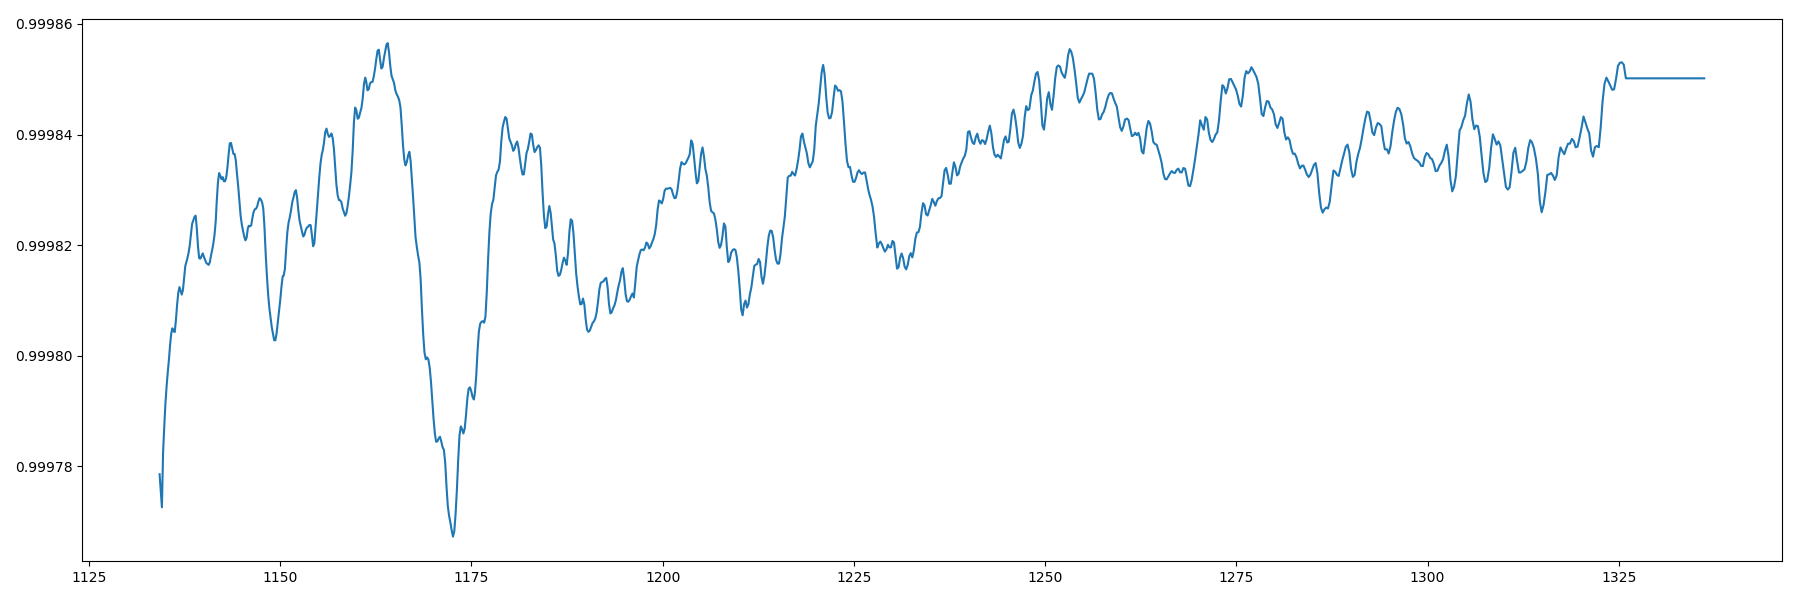

In [93]:
plt.figure(figsize=(18,6))
plt.plot(wvnr,D/D_intcalsource)
plt.tight_layout()
theta = D/D_intcalsource

In [25]:
rand = np.random.uniform(-1.,1.,1000)
beta = 0.69696969697

In [26]:
# zero incidence angle
avg_FP0 = 0
for rand in np.random.uniform(-1.,1.,1000):
    avg_FP0 += funcs.FPfunc(wvnr,R,D,beta*rand)
avg_FP0 /= 1000.

# incidence angle corrected
avg_FP = 0
for phase in np.linspace(-0.69696969697,0.69696969697,1000):
    avg_FP += funcs.FPfunc(wvnr,R,D,phase,theta=np.arccos(theta) )
avg_FP /= 1000.

NameError: name 'theta' is not defined

<IPython.core.display.Javascript object>


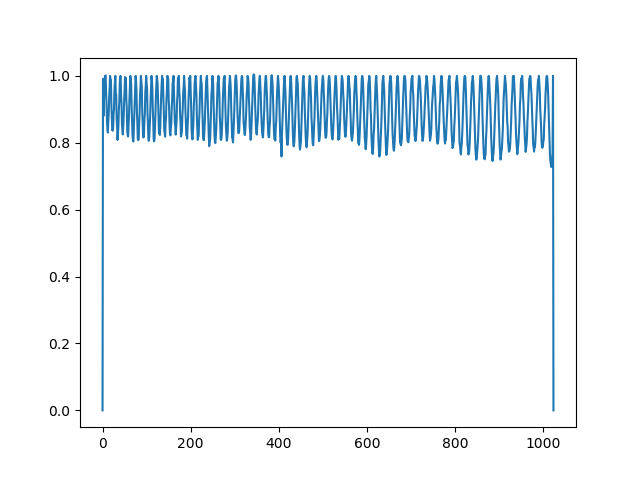

In [79]:
ext_data  = fm_extsource_sciimg[ypos,xpos]
ext_data[np.isnan(ext_data)] = -1
ext_peaks = funcs.find_peaks(ext_data,thres=0.,min_dist=min_dist)
ext_data[(ext_data == -1)] = np.nan
ext_data_noNaN = ext_data.copy()
ext_data_noNaN[np.isnan(ext_data)] = 0.
arr_interpolator = scp_interpolate.InterpolatedUnivariateSpline(ext_peaks,ext_data_noNaN[ext_peaks],k=3,ext=3)
ext_data_profile = arr_interpolator(range(len(ext_data_noNaN)))

plt.figure()
plt.plot(ext_data_noNaN/ext_data_profile)

<IPython.core.display.Javascript object>


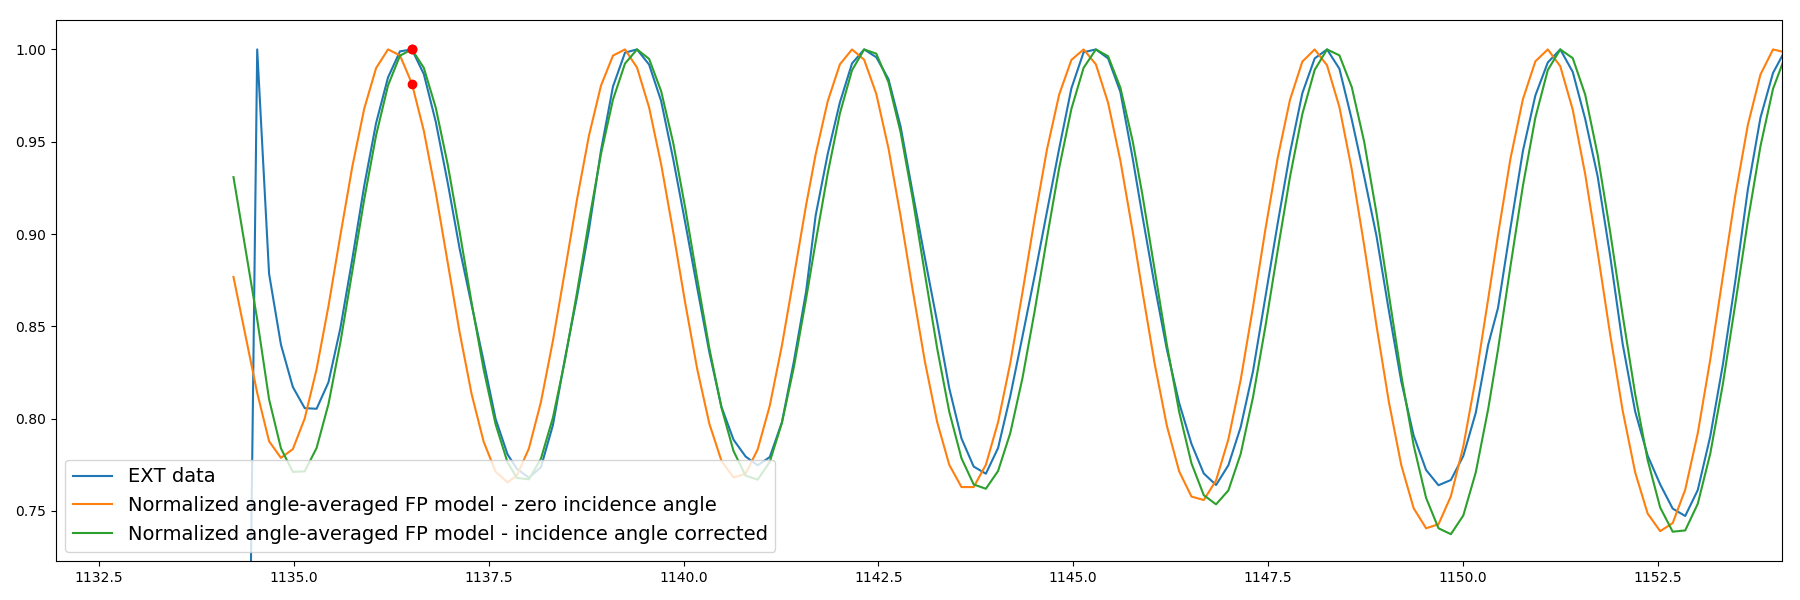

<IPython.core.display.Javascript object>


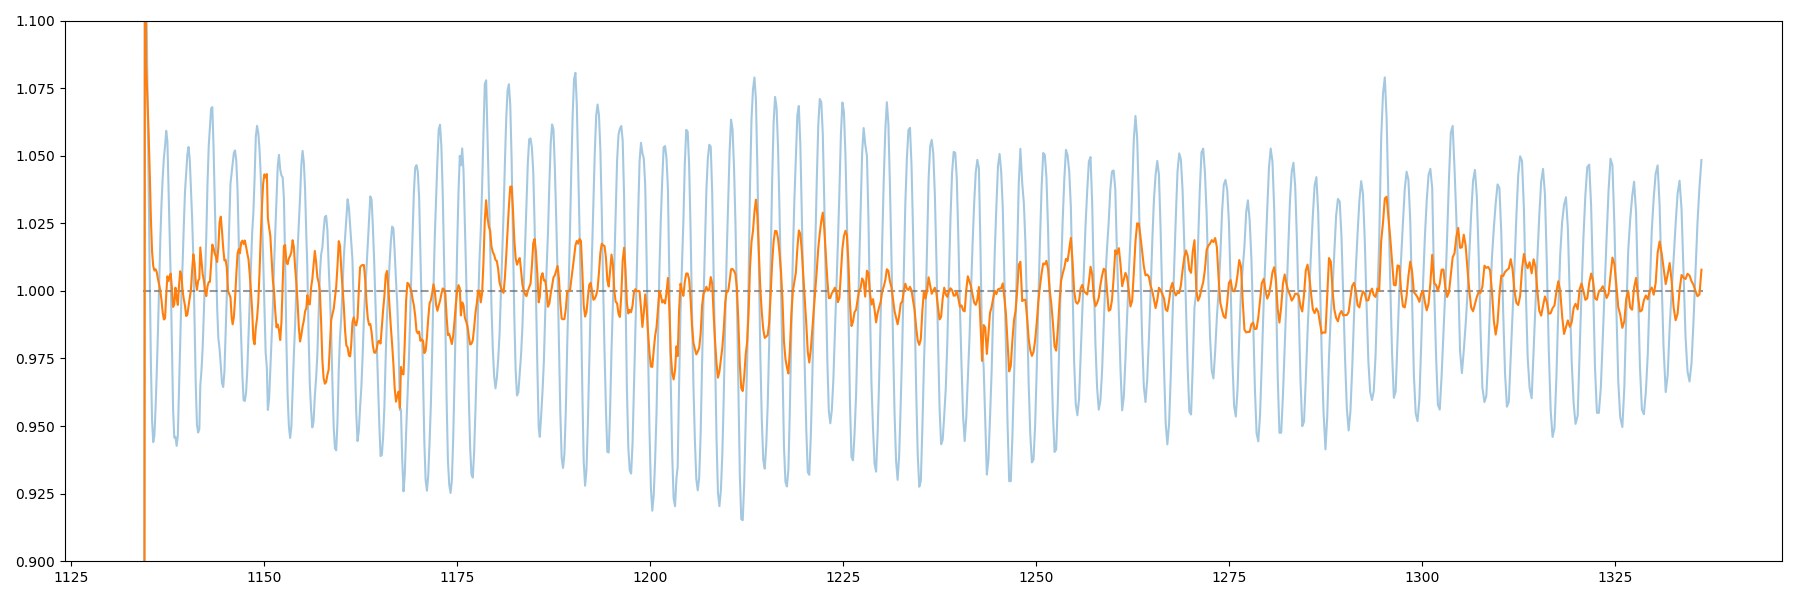

In [127]:
plt.close('all')

data0  = avg_FP0[~np.isnan(TR)]
data0[np.isnan(data0)] = -1
peaks0 = funcs.find_peaks(data0,thres=0.,min_dist=5)
data0[(data0 == -1)] = np.nan
data_noNaN0 = data0.copy()
data_noNaN0[np.isnan(data0)] = 0.
arr_interpolator0 = scp_interpolate.InterpolatedUnivariateSpline(peaks0,data_noNaN0[peaks0],k=3,ext=3)
data_profile0 = arr_interpolator0(range(len(data_noNaN0)))

data  = avg_FP[~np.isnan(TR)]
data[np.isnan(data)] = -1
peaks = funcs.find_peaks(data,thres=0.,min_dist=5)
data[(data == -1)] = np.nan
data_noNaN = data.copy()
data_noNaN[np.isnan(data)] = 0.
arr_interpolator = scp_interpolate.InterpolatedUnivariateSpline(peaks,data_noNaN[peaks],k=3,ext=3)
data_profile = arr_interpolator(range(len(data_noNaN)))

plt.figure(figsize=(18,6))
# plt.plot(wvnr[~np.isnan(TR)],TR[~np.isnan(TR)],label='FP model')
# plt.plot(wvnr[~np.isnan(TR)],avg_FP[~np.isnan(TR)],label='Angle-averaged FP model')
plt.plot(np.flipud(wvnrMap[ypos,xpos])[omit_nan][~np.isnan(TR)],np.flipud((ext_data_noNaN/ext_data_profile))[omit_nan][~np.isnan(TR)],label='EXT data')
plt.plot(wvnr[~np.isnan(TR)],data_noNaN0/data_profile0,label='Normalized angle-averaged FP model - zero incidence angle')
plt.plot(wvnr[~np.isnan(TR)],data_noNaN/data_profile,label='Normalized angle-averaged FP model - incidence angle corrected')
plt.ylim(0.7,1.1)
plt.legend(loc='best',fontsize=14)
plt.tight_layout()

plt.figure(figsize=(18,6))
plt.plot(wvnr[~np.isnan(TR)],np.flipud((ext_data_noNaN/ext_data_profile))[omit_nan][~np.isnan(TR)]/(data_noNaN0/data_profile0),alpha=0.4)
plt.plot(wvnr[~np.isnan(TR)],np.flipud((ext_data_noNaN/ext_data_profile))[omit_nan][~np.isnan(TR)]/(data_noNaN/data_profile) )
plt.hlines(1,wvnr[0],wvnr[-1],alpha=0.4,linestyle='dashed')
plt.ylim(0.9,1.1)
plt.tight_layout()

In [102]:
chi_square = []
for angle in np.linspace(0,1,100):
    avg_FP = 0
    for phase in np.linspace(-angle,angle,1000):
        avg_FP += funcs.FPfunc(wvnr,R,D,phase,theta=np.arccos(theta) )
    avg_FP /= 1000.
    
    data  = avg_FP[~np.isnan(TR)]
    data[np.isnan(data)] = -1
    peaks = funcs.find_peaks(data,thres=0.,min_dist=5)
    data[(data == -1)] = np.nan
    data_noNaN = data.copy()
    data_noNaN[np.isnan(data)] = 0.
    arr_interpolator = scp_interpolate.InterpolatedUnivariateSpline(peaks,data_noNaN[peaks],k=3,ext=3)
    data_profile = arr_interpolator(range(len(data_noNaN)))
    
    chi_square.append(np.sum(np.flipud((ext_data_noNaN/ext_data_profile)[omit_nan])[~np.isnan(TR)]/(data_noNaN/data_profile) -1 )**2)

<IPython.core.display.Javascript object>


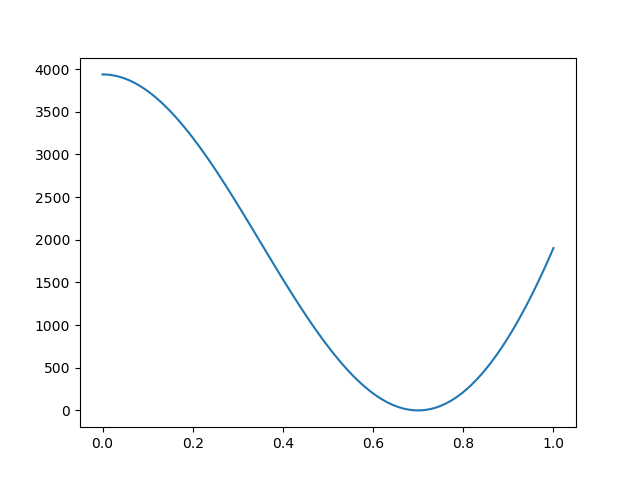

0.69696969697
39.9334220849


In [128]:
plt.figure()
plt.plot(np.linspace(0,1,100),chi_square)
print np.linspace(0,1,100)[np.argmin(np.array(chi_square))]
print np.linspace(0,1,100)[np.argmin(np.array(chi_square))]*180./np.pi

# Experiment: Compare Int Cal Source with point source

In [8]:
band     = '2A'                    # this is the spectral band (side of the slope image) to be analyzed
d2cMaps  = d2cMapping(band,cdpDir) # here, d2c stands for detector to cube transformation, from x,y integer pixel coordinates, to alpha, beta, and wavelength coordinates
# extract single maps
sliceMap  = d2cMaps['sliceMap']
alphaMap  = d2cMaps['alphaMap']
betaMap   = d2cMaps['betaMap']
lambdaMap = d2cMaps['lambdaMap']
wvnrMap   = 1./(lambdaMap/10000.)
nslices   = maux.MRS_nslices[band[0]]
bzero     = d2cMaps['bzero']
bdel      = d2cMaps['bdel']
mrs_fwhm  = maux.MRS_FWHM[band[0]]

bandlims = [lambdaMap[np.nonzero(lambdaMap)].min(),lambdaMap[np.nonzero(lambdaMap)].max()]
fov_lims = [alphaMap[np.nonzero(lambdaMap)].min(),alphaMap[np.nonzero(lambdaMap)].max()]
unique_betas = np.sort(np.unique(betaMap[(sliceMap>100*int(band[0])) & (sliceMap<100*(int(band[0])+1))]))

# cpd files
fringe_file,photom_file,psf_file,resol_file = funcs.get_cdps(cdpDir=cdpDir,band=band)

fringe_img     = fits.open(fringe_file)[1].data        # [unitless]
photom_img     = fits.open(photom_file)[1].data        # [DN/s * pixel/mJy]
pixsiz_img     = fits.open(photom_file)[5].data        # [arcsec^2/pix]
psffits        = fits.open(psf_file)                   # [unitless]
specres_table  = fits.open(resol_file)[1].data         # [unitless]

In [9]:
fm_pointsource_sciimg = fits.open(PointSource_scifile)[0].data[0,:,:]
# odd-even row signal correction
fm_pointsource_sciimg   = funcs.OddEvenRowSignalCorrection(fm_pointsource_sciimg)
# straylight correction
fm_pointsource_sciimg   = funcs.straylightCorrection(fm_pointsource_sciimg,sliceMap)


In [10]:
lambcens,lambfwhms = funcs.spectral_gridding(band=band,d2cMaps=d2cMaps,specres_table=specres_table)
source_center_slice,sign_amps,alpha_centers,alpha_sigmas,bkg_amps = funcs.point_source_along_slice_centroiding(band=band,sci_img=fm_pointsource_sciimg,d2cMaps=d2cMaps,spec_grid=[lambcens,lambfwhms])

Slice 8 has the largest summed flux


In [16]:
sign_amps2 = np.zeros(len(sign_amps))
sign_amps2[0] = sign_amps[0]
for i in range(len(sign_amps2)-2):
    sign_amps2[i+1] = (((sign_amps[i]+sign_amps[i+2])/2.)+sign_amps[i+1])/2.

<IPython.core.display.Javascript object>


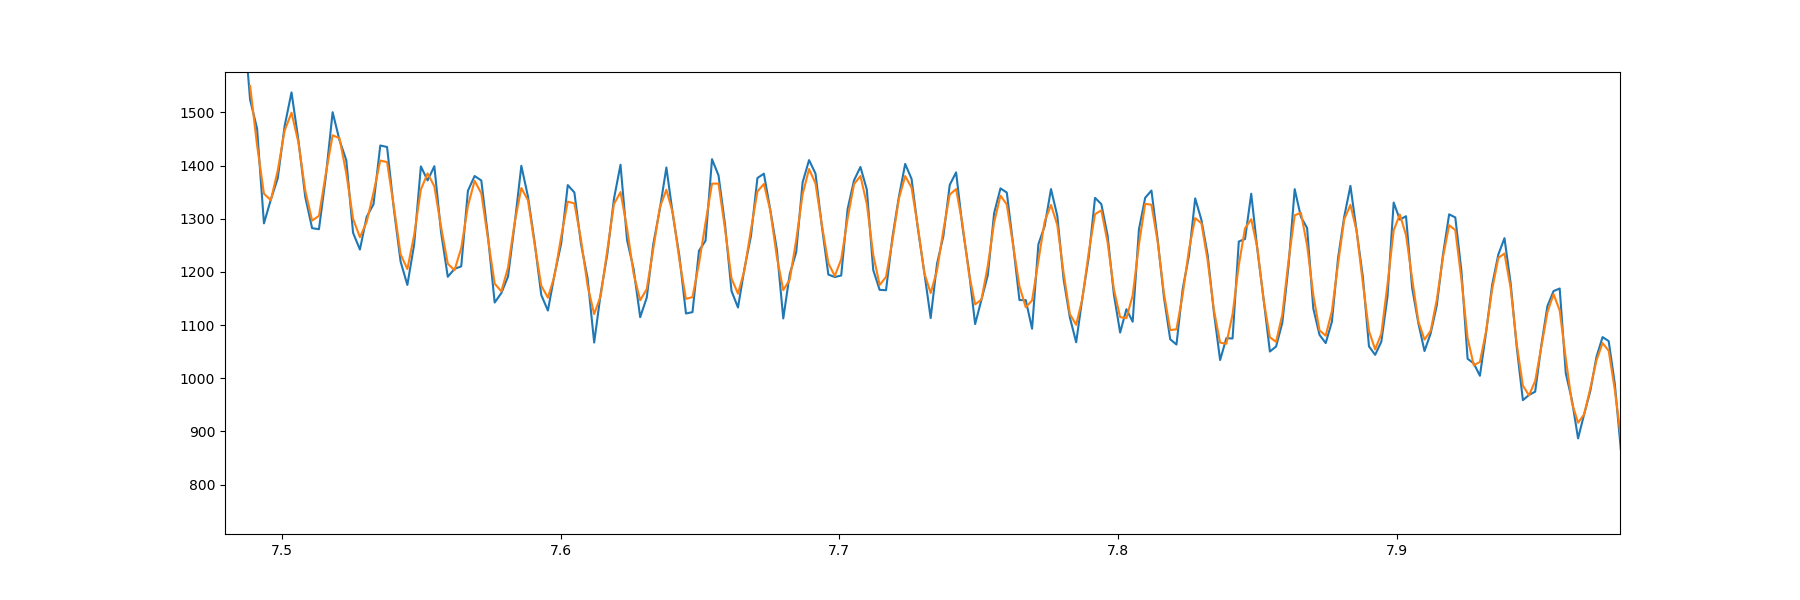

In [17]:
plt.figure(figsize=frame)
plt.plot(lambcens,sign_amps*330)
plt.plot(lambcens,sign_amps2*330)
# plt.plot(lambdaMap[ypos,xpos],fm_pointsource_sciimg[ypos,xpos]*340)
# plt.plot(lambdaMap[ypos,xpos],fm_extsource_sciimg[ypos,xpos]*25)
# plt.plot(lambdaMap[ypos,xpos],otis_intcalsource_sciimg[ypos,xpos])
# plt.plot(lambdaMap[ypos,xpos-1],fm_pointsource_sciimg[ypos,xpos-1]*1.71)

In [12]:
islice = source_center_slice
slice_img,alpha_img,lambda_img = [np.zeros(det_dims) for j in range(3)]
sel_pix = (sliceMap == 100*int(band[0])+islice) # select pixels with correct slice number
slice_img[sel_pix] = sliceMap[sel_pix] # image containing single slice
alpha_img[sel_pix] = alphaMap[sel_pix] # image containing single slice
lambda_img[sel_pix] = lambdaMap[sel_pix] # image containing single slice

In [13]:
ypos,xpos = np.arange(det_dims[0]),np.zeros(det_dims[0])
for row in ypos:
    coords = np.nonzero(slice_img[row,:])[0]
    xpos[row] = coords[np.argmax(fm_pointsource_sciimg[row,coords])]
xpos = xpos.astype(int)

<IPython.core.display.Javascript object>


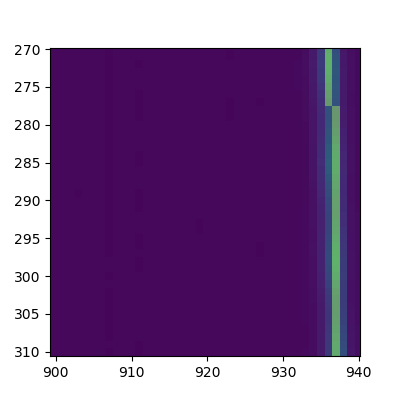

<IPython.core.display.Javascript object>


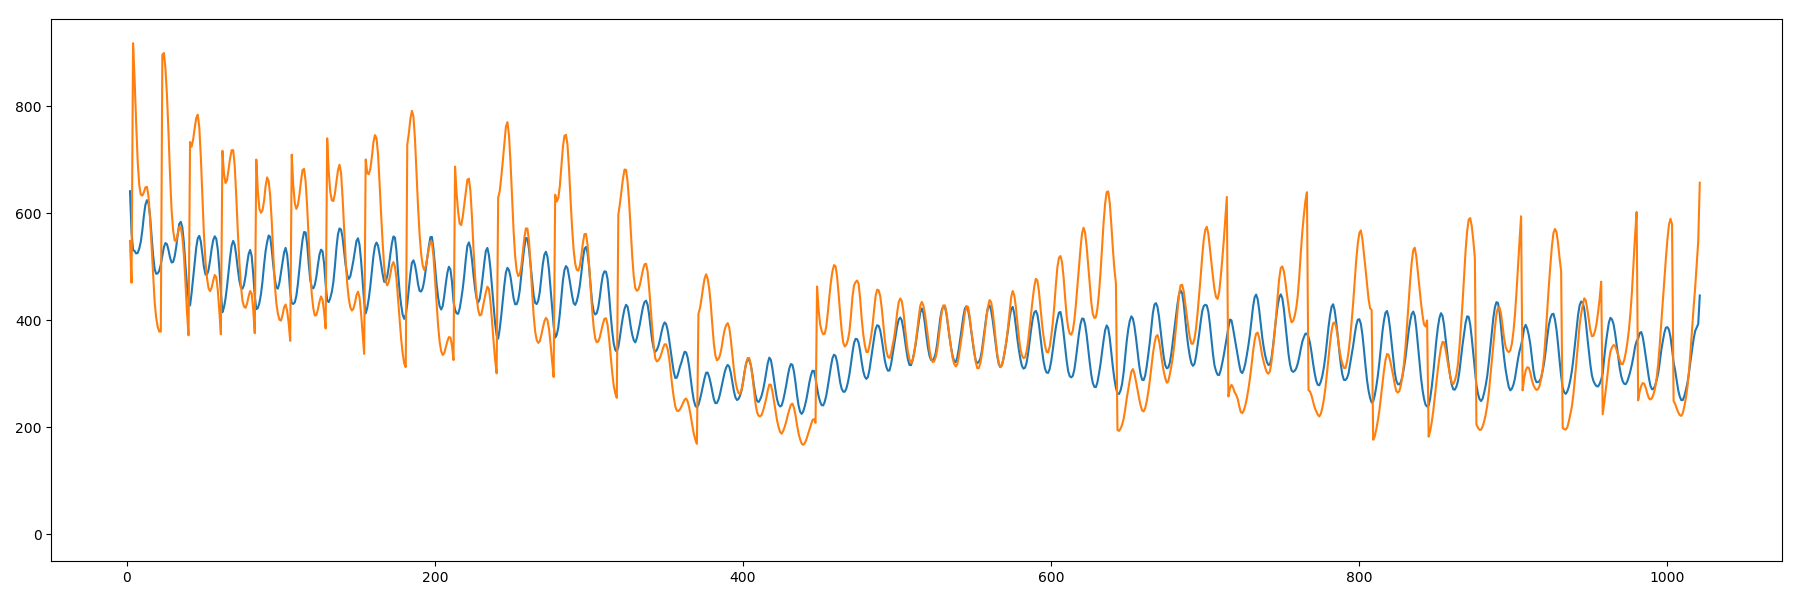

In [19]:
validMap = np.zeros(det_dims)
validMap[ypos,xpos] = 1

plt.figure(figsize=(4,4))
plt.imshow(fm_pointsource_sciimg,zorder=0)
plt.imshow(validMap,alpha=0.3,zorder=1)

plt.figure(figsize=frame)
# plt.imshow(validMap)
plt.plot(fm_pointsource_sciimg[ypos,xpos]*130.)
# # plt.plot(fm_extsource_sciimg[ypos,xpos]*18)
# # plt.plot(otis_intcalsource_sciimg[ypos,xpos])
plt.plot(fm_pointsource_sciimg[ypos,xpos-1]*225.)
# # plt.plot(otis_intcalsource_sciimg[ypos,xpos-1])
# plt.plot(fm_pointsource_sciimg[ypos,xpos+1]*280.)
# # plt.plot(otis_intcalsource_sciimg[ypos,xpos+1])
plt.tight_layout()

Min_dist between subsequent peaks: 6 elements (pixels)
Case 3


<IPython.core.display.Javascript object>


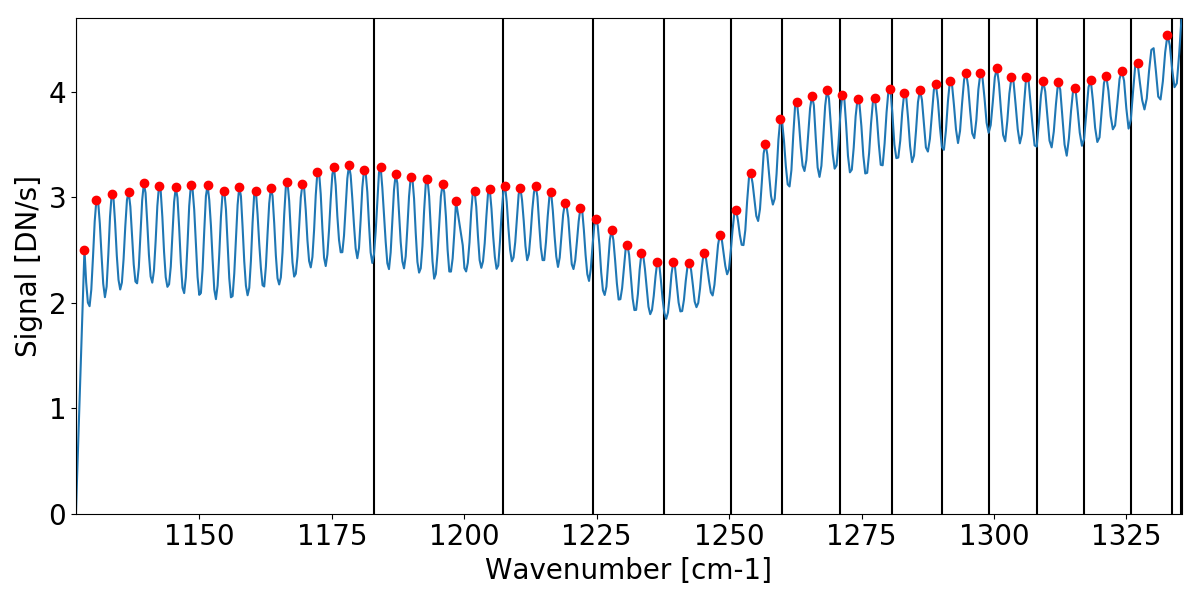

<IPython.core.display.Javascript object>


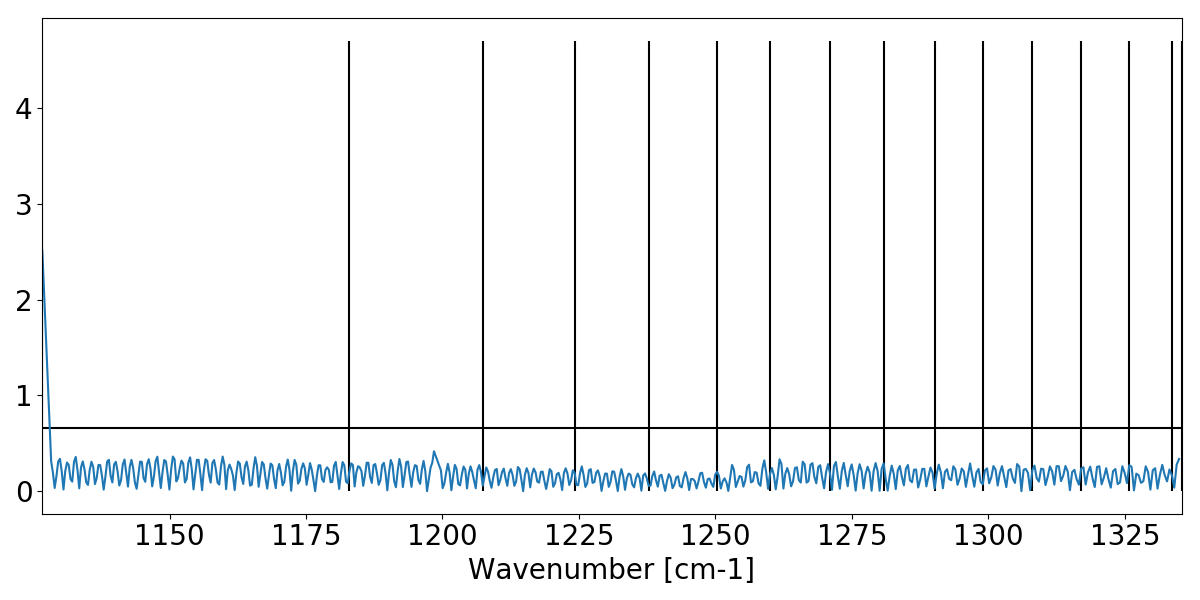

<IPython.core.display.Javascript object>


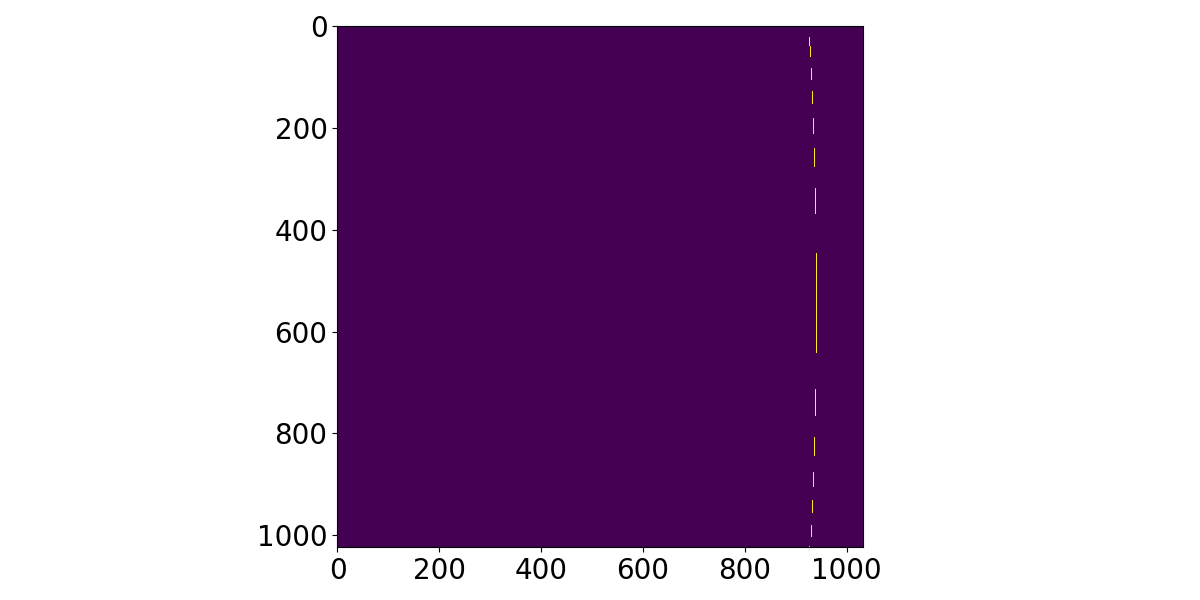

In [21]:
# extract spectrum
wvnr = np.flipud(10000./lambcens)
extracted_spectrum = np.flipud(sign_amps2)

# fringe peaks are found according to two parameters
# 1) threshold
thres = 0
# 2) minimum distance between subsequent peaks
detsubstrfringe_wvnr_spacing = (1/0.17)/2. # assuming the detector substrate is always the dominant source of fringing
min_dist = 0
while wvnr[len(wvnr)/2]-wvnr[len(wvnr)/2 - min_dist]<detsubstrfringe_wvnr_spacing :
    min_dist+=1
min_dist = int(round(min_dist/1.6))
print 'Min_dist between subsequent peaks: {} elements (pixels)'.format(min_dist)

# jumps/drops in signal due to displacement in pixel column
discont_idxs = np.unique(np.sort(len(extracted_spectrum)-1-1-np.where((np.abs(np.diff(xpos))>=1))[0]))+1
discont_idxs = np.concatenate([discont_idxs,np.array([len(extracted_spectrum)-1])])

# omit sections with too few elements
bad_sections = []
for i in range(len(discont_idxs)-1):
    if discont_idxs[i+1]-discont_idxs[i] <= min_dist:
        if discont_idxs[i+1] == -1:
            extracted_spectrum[discont_idxs[i]:] = np.nan
            bad_sections.extend([i,i+1])
        elif discont_idxs[i] == 0:
            extracted_spectrum[:discont_idxs[i+1]] = np.nan
            bad_sections.extend([i,i+1])
        else:
            extracted_spectrum[discont_idxs[i]-1:discont_idxs[i+1]+1] = np.nan
            bad_sections.extend([i,i+1])
discont_idxs = np.delete(discont_idxs,bad_sections)

omit_nan = ~np.isnan(extracted_spectrum).copy()
wvnr_noNaN = wvnr[omit_nan]
extracted_spectrum_noNaN = extracted_spectrum[omit_nan]

# second iteration
discont_idxs = np.unique(np.sort(len(extracted_spectrum_noNaN)-1-1-np.where((np.abs(np.diff(xpos[np.flipud(omit_nan)]))>=1))[0]))+1
if discont_idxs[0] != 0:
    discont_idxs = np.concatenate((np.array([0]),discont_idxs))
if discont_idxs[-1] != len(extracted_spectrum_noNaN)-1:
    discont_idxs = np.concatenate((discont_idxs,np.array([len(extracted_spectrum_noNaN)-1])))

outlier_condition = 5*np.std(np.abs(np.diff(extracted_spectrum_noNaN))) # five sigma
outliers = np.where(np.abs(np.diff(extracted_spectrum_noNaN)) > outlier_condition)[0]
invalid_outlier_idxs = [i for i in range(len(outliers)) if outliers[i] in discont_idxs-1]
outliers = np.delete(outliers,invalid_outlier_idxs)

test_case = funcs.find_peaks(np.abs(np.diff(extracted_spectrum_noNaN)),thres=outlier_condition/np.max(np.abs(np.diff(extracted_spectrum_noNaN))),min_dist=min_dist)
invalid_testcase_idxs = [i for i in range(len(test_case)) if test_case[i] in outliers]
test_case = np.delete(test_case,invalid_testcase_idxs)
if (len(test_case) != 0) & (set(test_case).issubset(discont_idxs[(discont_idxs!=0)]-1)) & (np.mean(alpha_centers[~np.isnan(alpha_centers)]) < 0):
    case = '1'
elif (len(test_case) != 0) & (set(test_case).issubset(discont_idxs[(discont_idxs!=0)]-1)) & (np.mean(alpha_centers[~np.isnan(alpha_centers)]) > 0):
    case = '2'
else:
    case = '3'
print 'Case {}'.format(case)

if case in ['1','2']:
    peaks_idxs = []
    pseudo_wvnr = []
    pseudo_contin = []
    for i in range(len(discont_idxs)-1):
        idx1,idx2 = discont_idxs[i],discont_idxs[i+1]
        pseudo_continuum = ((extracted_spectrum_noNaN[idx2-1]-extracted_spectrum_noNaN[idx1])/(wvnr_noNaN[idx2-1]-wvnr_noNaN[idx1]))*(np.linspace(wvnr_noNaN[idx1],wvnr_noNaN[idx2],idx2-idx1)-wvnr_noNaN[idx1])+extracted_spectrum_noNaN[idx1]
        # could try a 4th order polynomial for the pseudo_continuum, but too time consuming?..
        peak_idxs = idx1+funcs.find_peaks(extracted_spectrum_noNaN[idx1:idx2]-pseudo_continuum,thres=thres,min_dist=min_dist)
        invalid_peaks = [j for j in range(len(peak_idxs)) if peak_idxs[j] in outliers+1]
        peak_idxs = np.delete(peak_idxs,invalid_peaks)
        peaks_idxs.extend(peak_idxs)
        pseudo_wvnr.extend(wvnr_noNaN[idx1:idx2])
        pseudo_contin.extend(pseudo_continuum)
elif case == '3':
    peaks_idxs = funcs.find_peaks(extracted_spectrum_noNaN,thres=thres,min_dist=min_dist)

plt.close('all')
plt.figure(figsize=(12,6))
plt.plot(wvnr_noNaN,extracted_spectrum_noNaN)
if case in ['1','2']:
    plt.plot(pseudo_wvnr,pseudo_contin)
plt.plot(wvnr_noNaN[peaks_idxs],extracted_spectrum_noNaN[peaks_idxs],'ro')
plt.vlines(wvnr_noNaN[discont_idxs],extracted_spectrum_noNaN.min(),extracted_spectrum_noNaN.max())
plt.xlim(wvnr_noNaN.min(),wvnr_noNaN.max())
plt.ylim(extracted_spectrum_noNaN.min(),extracted_spectrum_noNaN.max())
plt.xlabel('Wavenumber [cm-1]',fontsize=20)
plt.ylabel('Signal [DN/s]',fontsize=20)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()

plt.figure(figsize=(12,6))
plt.plot(wvnr_noNaN[:-1],np.abs(np.diff(extracted_spectrum_noNaN)) )
plt.plot(wvnr_noNaN[:-1][test_case],np.abs(np.diff(extracted_spectrum_noNaN))[test_case],'ro' )
plt.hlines(outlier_condition,wvnr_noNaN.min(),wvnr_noNaN.max())
plt.vlines(wvnr_noNaN[discont_idxs],extracted_spectrum_noNaN.min(),extracted_spectrum_noNaN.max())
plt.xlim(wvnr_noNaN.min(),wvnr_noNaN.max())
plt.xlabel('Wavenumber [cm-1]',fontsize=20)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()

# Spectrum origination on detector
img2 = np.full(det_dims,0.)
img2[ypos,xpos] = 1

plt.figure(figsize=(12,6))
plt.imshow(img2,zorder=0)
# plt.imshow(sliceMap,alpha=0.4,zorder=1)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()


<IPython.core.display.Javascript object>


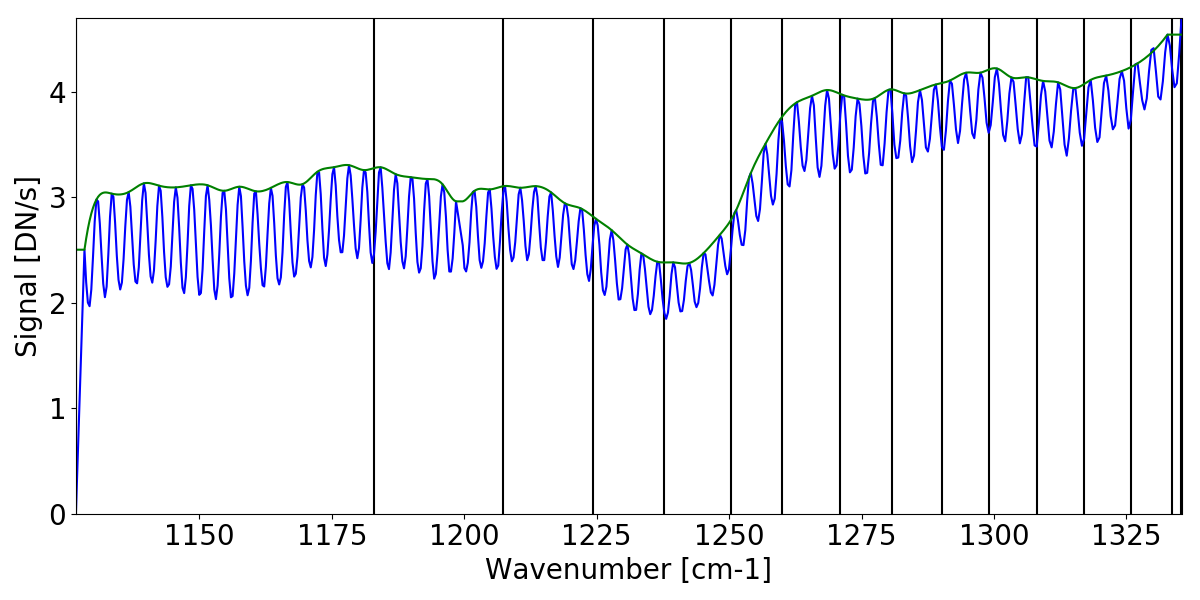

<IPython.core.display.Javascript object>


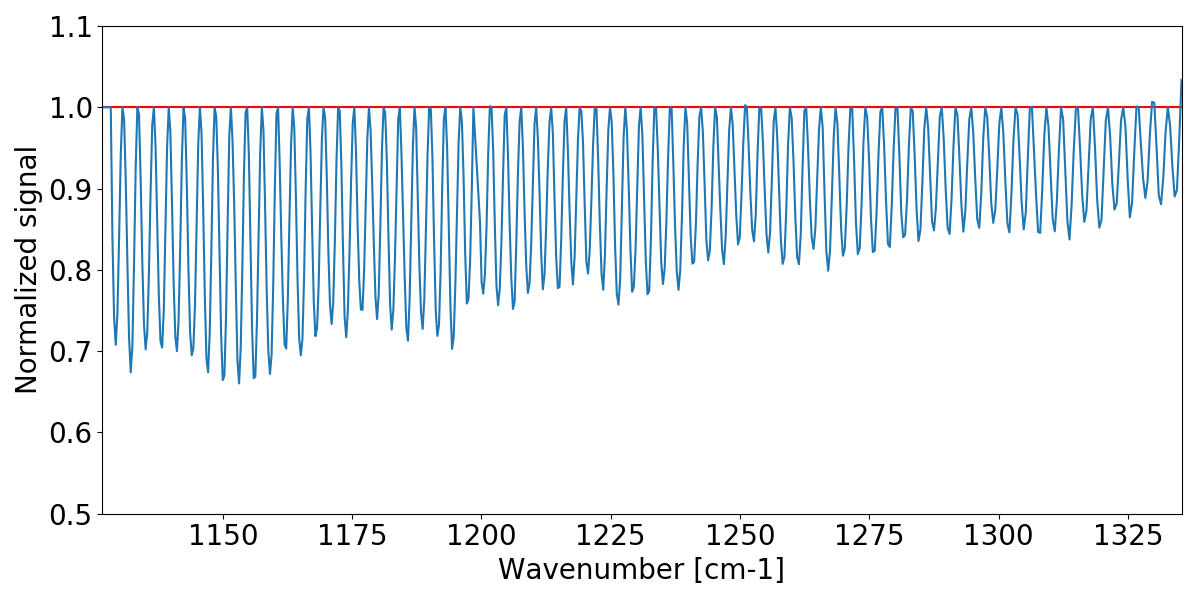

In [22]:
# Scale to 1d spectrum continuum level (defined by fringe peaks)
#-- construct continuum level
if case in ['1','2']:
    arr_profile = []
    for i in range(len(discont_idxs)-1):
        idx1,idx2 = discont_idxs[i],discont_idxs[i+1]
        if idx2 == len(extracted_spectrum_noNaN)-1:
            pseudo_continuum = ((extracted_spectrum_noNaN[len(extracted_spectrum_noNaN)-1]-extracted_spectrum_noNaN[idx1])/(wvnr_noNaN[len(extracted_spectrum_noNaN)-1]-wvnr_noNaN[idx1]))*(np.linspace(wvnr_noNaN[idx1],wvnr_noNaN[len(extracted_spectrum_noNaN)-1],len(extracted_spectrum_noNaN)-idx1)-wvnr_noNaN[idx1])+extracted_spectrum_noNaN[idx1]
            peak_idxs = funcs.find_peaks(extracted_spectrum_noNaN[idx1:]-pseudo_continuum,thres=thres,min_dist=min_dist)
            invalid_peaks = [j for j in range(len(peak_idxs)) if idx1+peak_idxs[j] in outliers+1]
            peaks_idxs = np.delete(peak_idxs,invalid_peaks)
            if len(peaks_idxs) == 2:
                arr_interpolator = scp_interpolate.InterpolatedUnivariateSpline(peaks_idxs,extracted_spectrum_noNaN[idx1:][peaks_idxs],k=1,ext=0)
                arr_profile.extend(arr_interpolator(range(len(extracted_spectrum_noNaN[idx1:]))) )
            elif len(peaks_idxs) == 3:
                arr_interpolator = scp_interpolate.InterpolatedUnivariateSpline(peaks_idxs,extracted_spectrum_noNaN[idx1:][peaks_idxs],k=2,ext=0)
                arr_profile.extend(arr_interpolator(range(len(extracted_spectrum_noNaN[idx1:]))) )
            elif len(peaks_idxs) > 3:
                arr_interpolator = scp_interpolate.InterpolatedUnivariateSpline(peaks_idxs,extracted_spectrum_noNaN[idx1:][peaks_idxs],k=3,ext=0)
                arr_profile.extend(arr_interpolator(range(len(extracted_spectrum_noNaN[idx1:]))) )
            else:
                arr_profile.extend(extracted_spectrum_noNaN[idx1:])
        else:
            pseudo_continuum = ((extracted_spectrum_noNaN[idx2-1]-extracted_spectrum_noNaN[idx1])/(wvnr_noNaN[idx2-1]-wvnr_noNaN[idx1]))*(np.linspace(wvnr_noNaN[idx1],wvnr_noNaN[idx2],idx2-idx1)-wvnr_noNaN[idx1])+extracted_spectrum_noNaN[idx1]
            peak_idxs = funcs.find_peaks(extracted_spectrum_noNaN[idx1:idx2]-pseudo_continuum,thres=thres,min_dist=min_dist)
            invalid_peaks = [j for j in range(len(peak_idxs)) if idx1+peak_idxs[j] in outliers+1]
            peaks_idxs = np.delete(peak_idxs,invalid_peaks)
            if len(peaks_idxs) == 2:
                arr_interpolator = scp_interpolate.InterpolatedUnivariateSpline(peaks_idxs,extracted_spectrum_noNaN[idx1:idx2][peaks_idxs],k=1,ext=0)
                arr_profile.extend(arr_interpolator(range(len(extracted_spectrum_noNaN[idx1:idx2]))) )
            elif len(peaks_idxs) == 3:
                arr_interpolator = scp_interpolate.InterpolatedUnivariateSpline(peaks_idxs,extracted_spectrum_noNaN[idx1:idx2][peaks_idxs],k=2,ext=0)
                arr_profile.extend(arr_interpolator(range(len(extracted_spectrum_noNaN[idx1:idx2]))) )
            elif len(peaks_idxs) > 3:
                arr_interpolator = scp_interpolate.InterpolatedUnivariateSpline(peaks_idxs,extracted_spectrum_noNaN[idx1:idx2][peaks_idxs],k=3,ext=0)
                arr_profile.extend(arr_interpolator(range(len(extracted_spectrum_noNaN[idx1:idx2]))) )
            else:
                arr_profile.extend(extracted_spectrum_noNaN[idx1:idx2])
    arr_profile = np.array(arr_profile)
elif case == '3':
    peaks_idxs = funcs.find_peaks(extracted_spectrum_noNaN,thres=thres,min_dist=min_dist)
    arr_interpolator = scp_interpolate.InterpolatedUnivariateSpline(peaks_idxs,extracted_spectrum_noNaN[peaks_idxs],k=3,ext=3)
    arr_profile = arr_interpolator(range(len(extracted_spectrum_noNaN)))

plt.close('all')
plt.figure(figsize=(12,6))
plt.plot(wvnr_noNaN,extracted_spectrum_noNaN,'b')
plt.plot(wvnr_noNaN,arr_profile,'g')
# black lines indicate transition in pixel column (equivalent to visible jump/drop in signal)
plt.vlines(wvnr_noNaN[discont_idxs],extracted_spectrum_noNaN.min(),extracted_spectrum_noNaN.max())
plt.xlim(wvnr_noNaN.min(),wvnr_noNaN.max())
plt.ylim(extracted_spectrum_noNaN.min(),extracted_spectrum_noNaN.max())
plt.xlabel('Wavenumber [cm-1]',fontsize=20)
plt.ylabel('Signal [DN/s]',fontsize=20)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()

norm_profile = extracted_spectrum_noNaN/arr_profile
norm_profile[(norm_profile <= 0.6)] = 1 # fringe amplitude cannot be more that 40% of signal
norm_profile[(norm_profile >= 1.4)] = 1
    
plt.figure(figsize=(12,6))
plt.plot(wvnr_noNaN,norm_profile)
plt.hlines(1,wvnr_noNaN.min(),wvnr_noNaN.max(),'r')
plt.xlim(wvnr_noNaN.min(),wvnr_noNaN.max())
plt.ylim(0.5,1.1)
plt.xlabel('Wavenumber [cm-1]',fontsize=20)
plt.ylabel('Normalized signal',fontsize=20)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()


<IPython.core.display.Javascript object>


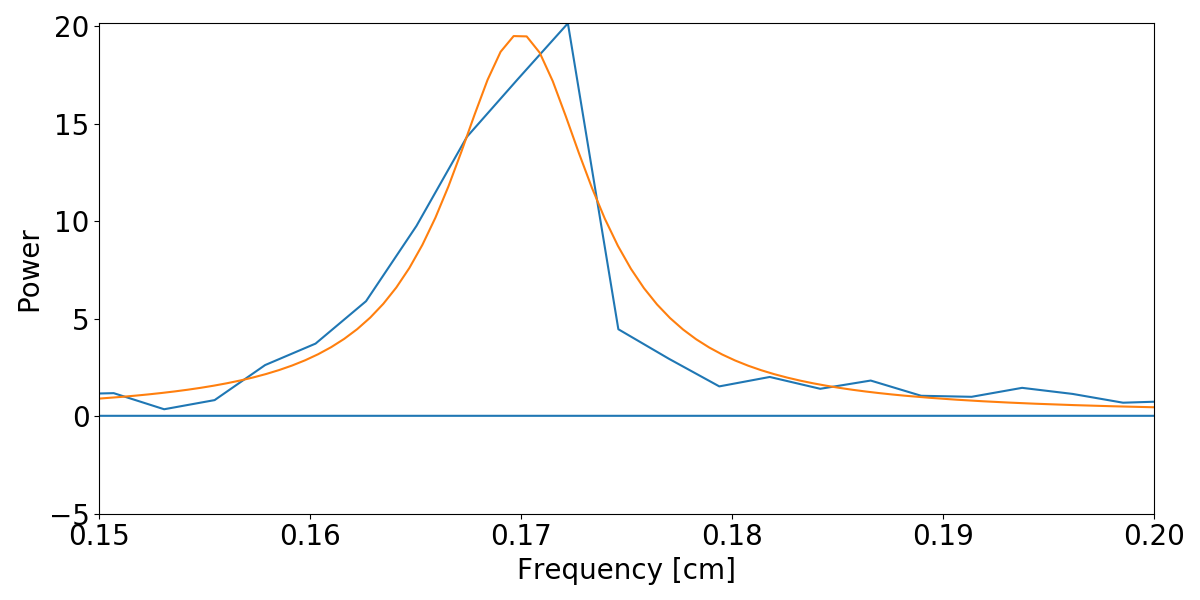

<IPython.core.display.Javascript object>


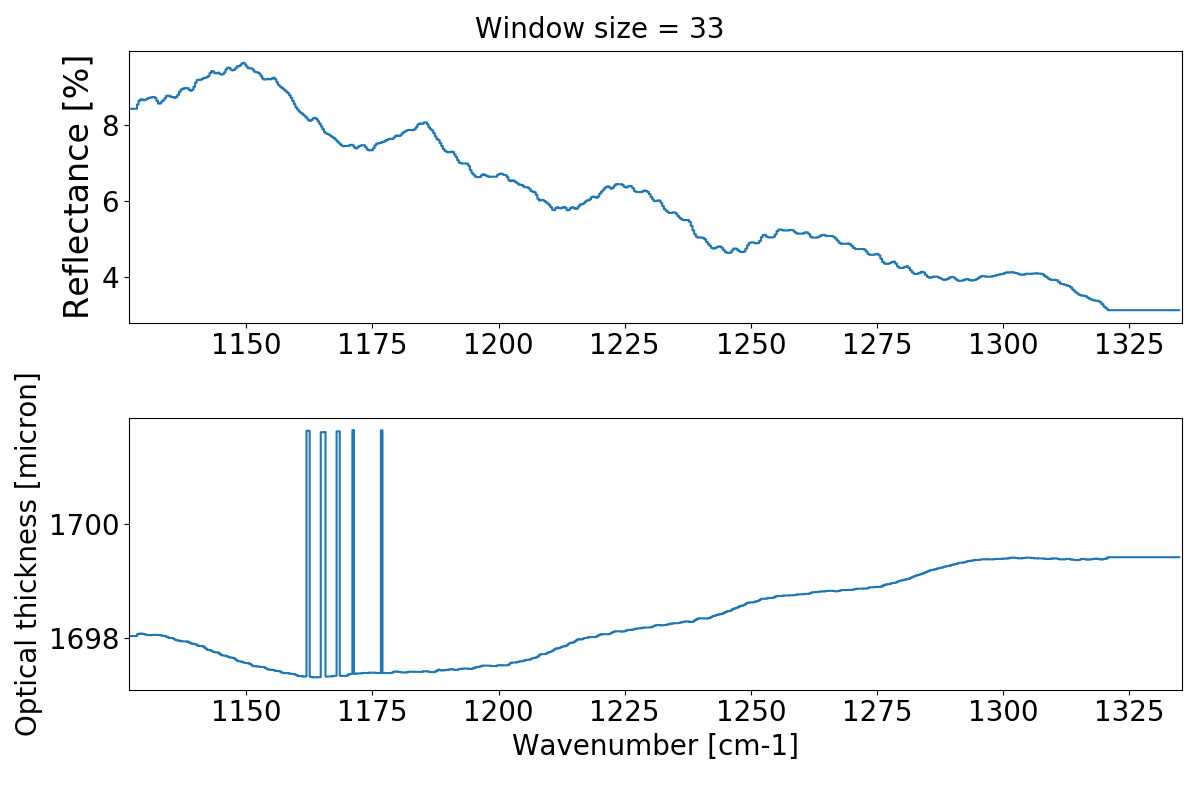

<IPython.core.display.Javascript object>


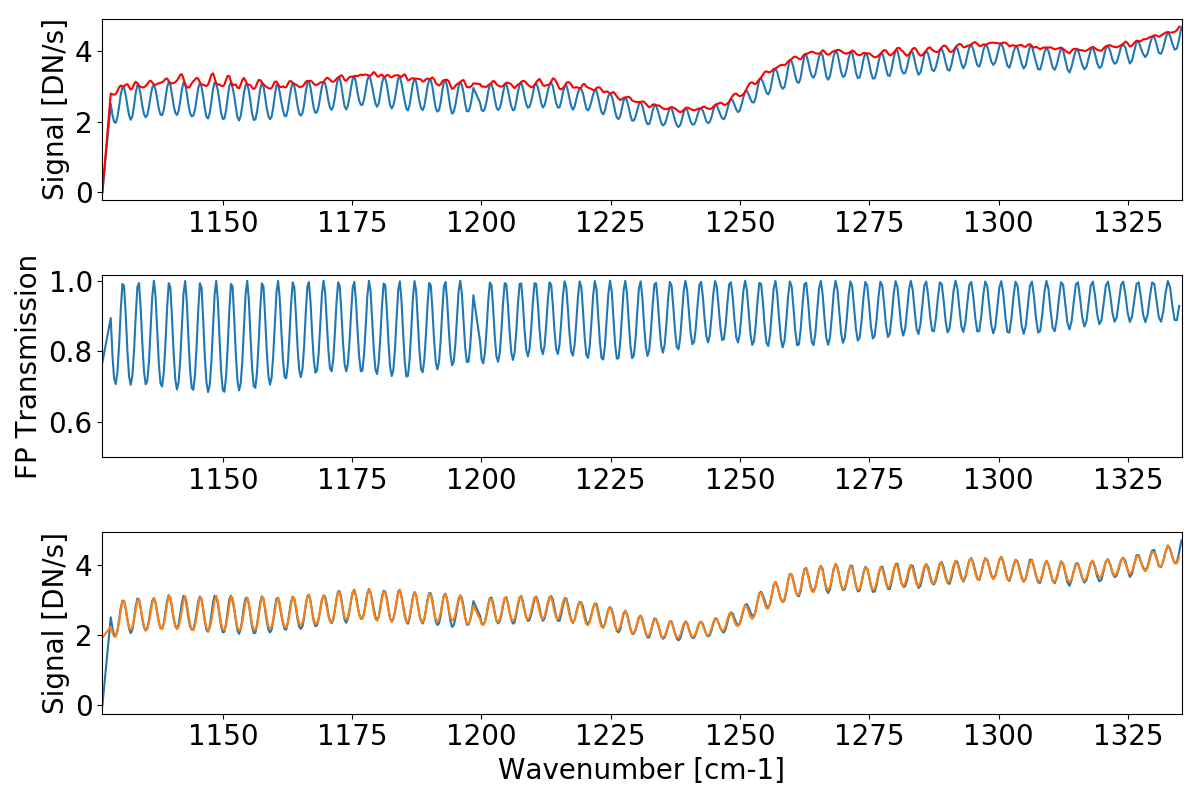

In [34]:
# perform above generic analysis, in shorter wavenumber segments
wvnr = wvnr_noNaN.copy()
arr  = norm_profile.copy()

wvnr_equi = np.linspace(wvnr[0],wvnr[-1],len(wvnr))
arr_equi  = scp_interpolate.interp1d(wvnr,arr)(wvnr_equi)

freq = np.fft.fftfreq(wvnr_equi.shape[-1],d=np.diff(wvnr_equi)[0])/2. # nyquist frequency
sp = np.fft.fft(arr_equi)
power = np.sqrt(sp.real**2 + sp.imag**2)

if case == '1':
    try:
        flag = 0
        continuum = signal.medfilt(power[~np.isnan(power)],kernel_size=21)
        popt0,pcov0 = curve_fit(funcs.lorentzian_profile,freq[freq>=0.1],(power-continuum)[freq>=0.1],p0=[np.max((power-continuum)[freq>=0.1]),freq[freq>=0.1][np.argmax((power-continuum)[freq>=0.1])],0.005])
    except RuntimeError:
        flag = 1
        popt0,pcov0 = curve_fit(funcs.lorentzian_profile,freq[freq>=0.1],power[freq>=0.1]-np.mean(power[(freq>=0.3)]),p0=[np.max(power[freq>=0.1]),freq[freq>=0.1][np.argmax(power[freq>=0.1])],0.005])
elif case in ['2','3']:
    flag = 0
    popt0,pcov0 = curve_fit(funcs.lorentzian_profile,freq[freq>=0.1],power[freq>=0.1]-np.mean(power[(freq>=0.3)]),p0=[np.max(power[freq>=0.1]),freq[freq>=0.1][np.argmax(power[freq>=0.1])],0.005])
# print np.max(power[freq>=0.1]),freq[freq>=0.1][np.argmax(power[freq>=0.1])]
# print popt0

if (case == '1') & (flag == 0):
    plt.figure(figsize=(12,6))
    plt.plot(freq,power)
    plt.plot(freq,continuum)
    plt.ylim(0,20)
    plt.xlabel('Frequency [cm]',fontsize=20)
    plt.ylabel('Power',fontsize=20)
    plt.tick_params(axis='both',labelsize=20)
    plt.tight_layout()

plt.figure(figsize=(12,6))
if (case == '1') & (flag == 0):
    plt.plot(freq,power-continuum)
    testx = np.linspace(freq[freq>=0.1][0],freq[freq>=0.1][-1],1000)
    testy = funcs.lorentzian_profile(testx,*popt0)
    plt.plot(testx,testy)
elif (case == '1') & (flag == 1):
    plt.plot(freq,power)
    testx = np.linspace(freq[freq>=0.1][0],freq[freq>=0.1][-1],1000)
    testy = funcs.lorentzian_profile(testx,*popt0)
    plt.plot(testx,testy+np.mean(power[(freq>=0.3)]))
elif case in ['2','3']:
    plt.plot(freq,power)
    testx = np.linspace(freq[freq>=0.1][0],freq[freq>=0.1][-1],1000)
    testy = funcs.lorentzian_profile(testx,*popt0)
    plt.plot(testx,testy+np.mean(power[(freq>=0.3)]))
plt.vlines([popt0[1]-5*popt0[2],popt0[1]+5*popt0[2]],-10,200)
plt.xlim(freq.min(),freq.max())
plt.xlim(0.15,0.20)
plt.ylim(-5,np.max(power[freq>=0.1]))
plt.xlabel('Frequency [cm]',fontsize=20)
plt.ylabel('Power',fontsize=20)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()


N=1 # number of wavenumber elements
period = 1/popt0[1]
while wvnr[N]-wvnr[0] < 2*period:
    N+=1
    
R0,D0 = 0.10,popt0[1]

R,D = [np.full(len(wvnr),np.nan) for j in range(2)]
sigma_R,sigma_D = [np.full(len(wvnr),np.nan) for j in range(2)]
for i in range(len(wvnr)-N):
# for i in [55]:
    wvnr_segment = wvnr[i: N+i].copy()
    arr_segment  = arr[i: N+i].copy()

    # least-squares fitting
    try: 
        popt,pcov = curve_fit(funcs.FPfunc_noPhaseShift,wvnr_segment,arr_segment,p0=(R0,D0),absolute_sigma=True,method='lm')
        TR = funcs.FPfunc_noPhaseShift(wvnr_segment,*popt)

        R[i: N+i] = popt[0]
        D[i: N+i] = popt[1]
        sigma_R[i: N+i] = np.sqrt(np.diag(pcov))[0]
        sigma_D[i: N+i] = np.sqrt(np.diag(pcov))[1]
        
    except RuntimeError: 
        continue

#-- Remove outliers
Rlower = 0.
Dlower,Dupper = 0.14,0.2 # cm, decision based on expected detector thickness (~0.17cm substrate)
R[np.where(R<Rlower)] = np.nan
D[np.where(R<Rlower)] = np.nan
R[np.where(D>Dupper)] = np.nan
R[np.where(D<Dlower)] = np.nan
D[np.where(D>Dupper)] = np.nan
D[np.where(D<Dlower)] = np.nan

fig,axs = plt.subplots(2,1,figsize=(12,8))
# axs[0].errorbar(wvnr,R*100,yerr=sigma_R*100,fmt='o',label='data')
# axs[0].step(wvnr_intcalsource,R_intcalsource*100,label='data')
axs[0].step(wvnr,R*100,label='data')
axs[0].set_xlim(wvnr[0],wvnr[-1])
# axs[0].set_ylim(0)
axs[0].set_ylabel('Reflectance [%]',fontsize=24)
axs[0].tick_params(axis='both',labelsize=20)
# axs[1].errorbar(wvnr,D*10000,yerr=sigma_D*10000,fmt='o',label='data')
# axs[1].step(wvnr_intcalsource,D_intcalsource*10000,label='data')
axs[1].step(wvnr,D*10000,label='data')
axs[1].set_xlim(wvnr[0],wvnr[-1])
axs[1].set_ylabel('Optical thickness [micron]',fontsize=20)
axs[1].tick_params(axis='both',labelsize=20)
axs[1].set_xlabel('Wavenumber [cm-1]',fontsize=20)
plt.suptitle('Window size = {}'.format(N),fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])

# plot result of FP fitting
arr  = extracted_spectrum_noNaN.copy()
reference = arr_profile.copy()

#> manual fitting
TR = (1 + (4*R/(1-R)**2) * np.sin(2*np.pi*D*wvnr*np.cos(0))**2 )**-1

#> compare with normalized extended source spectrum
ext_data  = fm_extsource_sciimg[ypos,xpos]
ext_data[np.isnan(ext_data)] = -1
ext_peaks = funcs.find_peaks(ext_data,thres=0.,min_dist=min_dist)
ext_data[(ext_data == -1)] = np.nan
ext_data_noNaN = ext_data.copy()
ext_data_noNaN[np.isnan(ext_data)] = 0.
arr_interpolator = scp_interpolate.InterpolatedUnivariateSpline(ext_peaks,ext_data_noNaN[ext_peaks],k=3,ext=3)
ext_data_profile = arr_interpolator(range(len(ext_data_noNaN)))


fig,axs = plt.subplots(3,1,figsize=(12,8))
axs[0].plot(wvnr,arr)
# axs[0].plot(test_wvnr,test_arr)
# axs[0].plot(wvnr,arr_profile)
axs[0].plot(wvnr[~np.isnan(TR)],arr[~np.isnan(TR)]/TR[~np.isnan(TR)],'r')
# axs[0].plot(np.flipud(1/(lambdaMap[ypos,xpos]/10000)),np.flipud(reduced_img[ypos,xpos]/fringe_img[ypos,xpos]),'c')
axs[0].set_xlim(wvnr[0],wvnr[-1])
axs[0].set_ylabel('Signal [DN/s]',fontsize=20)
axs[0].tick_params(axis='both',labelsize=20)
axs[1].plot(wvnr[~np.isnan(TR)],TR[~np.isnan(TR)])
# axs[1].plot(np.flipud(wvnrMap[ypos,xpos])[omit_nan][~np.isnan(TR)],np.flipud((ext_data_noNaN/ext_data_profile))[omit_nan][~np.isnan(TR)])
axs[1].set_xlim(wvnr[0],wvnr[-1])
axs[1].set_ylim(0.5)
axs[1].set_ylabel('FP Transmission',fontsize=20)
axs[1].tick_params(axis='both',labelsize=20)
axs[2].plot(wvnr,arr)
axs[2].plot(wvnr[~np.isnan(TR)],reference[~np.isnan(TR)]*TR[~np.isnan(TR)])
# axs[2].vlines([1915,1945],1900,2400,'g')
axs[2].set_xlim(wvnr[0],wvnr[-1])
axs[2].set_xlabel('Wavenumber [cm-1]',fontsize=20)
axs[2].set_ylabel('Signal [DN/s]',fontsize=20)
axs[2].tick_params(axis='both',labelsize=20)
plt.tight_layout()


## Summary:  
Insert summary here